In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

raw_loans = pd.read_csv('loan.csv', dtype={47: str}, low_memory=False)

# Use Seaborn's aesthetic
sns.set_theme()

# number of columns and rows
print("Number of columns: ", len(raw_loans.columns))
print("Number of rows: ", len(raw_loans))

Number of columns:  111
Number of rows:  39717


#### Remove unnecessary rows
- Remove loans that are still in progress

In [3]:
# remove loans that are still in progress
loans = raw_loans[raw_loans['loan_status'] != 'Current']

#### Clean up of columns
- Drop columns with all null values
- Drop columns with all same values

In [4]:
# Drop columns with all null values
nan_cols = loans.columns[loans.isna().all()].tolist()
print(len(nan_cols), "collumns have null values in all rows, these columns can be dropped")
loans = loans.drop(nan_cols, axis=1)

# Drop columns with only one unique value
unique_value_cols = loans.columns[loans.nunique() == 1]
print(len(unique_value_cols), "columns have only one unique value, these columns can be dropped as they do not provide any useful information")
loans = loans.drop(unique_value_cols, axis=1)

# Left with columns data
print("\n")
print("Columns left: ", len(loans.columns))

55 collumns have null values in all rows, these columns can be dropped
11 columns have only one unique value, these columns can be dropped as they do not provide any useful information


Columns left:  45


#### Remove outliers
Columns to remove outliers on:
 - loan_amnt
- funded_amnt
- annual_inc

In [5]:
raw_raw_count = len(raw_loans)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    return df.loc[filter]

# remove outliers
loans = remove_outliers(loans, 'loan_amnt')
loans = remove_outliers(loans, 'funded_amnt')
loans = remove_outliers(loans, 'annual_inc')

# calculate percentage of data removed
print("Percentage of data removed: ", round((1 - len(loans)/raw_raw_count) * 100, 2), "%")

Percentage of data removed:  10.11 %


#### Add new columns
- Add column for loan status (0 = not default, 1 = default)
- Add column for loan term (0 = 36 months, 1 = 60 months)
- Add column for loan grade (A-G)
- Add column for loan subgrade (1-5)
- Add column for loan home ownership (1-6)
- Add column for loan verification status (1-3)

- Add column for loan issue month (1-12)
- Add column for loan issue year (2007-2015)

- Add column for loan interest rate (0-30)

- Add column for percent funded (0-100)
- Add column for binning of percent funded (0-100)

- Add column for percent funded by investors (0-100)
- Add column for binning of percent funded by investors (0-100)

In [6]:
# add a new column to indicate if the loan is fully paid or not ( 0 - fully paid, 1 - defaulted)
loans['default'] = np.where(loans['loan_status'].isin(['Fully Paid']), 0, 100)

loans['term_num'] = loans['term'].apply(lambda x: int(x.split()[0]))

# convert issue_d to datetime
loans['issue_d'] = pd.to_datetime(loans['issue_d'], format='%b-%y')
loans['issue_month'] = loans['issue_d'].dt.month
loans['issue_year'] = loans['issue_d'].dt.year

# convert earliest_cr_line to datetime
loans['earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line'], format='%b-%y')

# convert last_pymnt_d to datetime
loans['last_pymnt_d'] = pd.to_datetime(loans['last_pymnt_d'], format='%b-%y')

# convert last_credit_pull_d to datetime
loans['last_credit_pull_d'] = pd.to_datetime(loans['last_credit_pull_d'], format='%b-%y')

# convert loan grade to numeric
loans['grade_num'] = loans['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

# convert loan sub grade to numeric
loans['sub_grade_num'] = loans['sub_grade'].map({'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                                                    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                                                    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                                                    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                                                    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                                                    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                                                    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35})

# convert loan sub grade to numeric
loans['emp_length_num'] = loans['emp_length'].map({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                                                    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
                                                    '10+ years': 10})

# convert loan grade and sub grade to combined numeric
loans['grade_sub_grade_num'] = loans['grade_num'] * 100 + loans['sub_grade_num'] * 20

# convert int_rate to numeric
loans['int_rate_num'] = loans['int_rate'].str.rstrip('%').astype('float')


In [7]:
loans = remove_outliers(loans, 'int_rate_num')

In [8]:
import numpy_financial as npf

def calc_interest_rate(row):
    return (npf.rate(row['term_num'], row['installment'], -row['funded_amnt'], 0) * 12 * 100).round(2)

loans['total_amount_to_pay'] = loans['installment'] * loans['term_num']
loans['total_interest'] = loans['total_amount_to_pay'] - loans['funded_amnt']
loans['total_loss'] = loans.apply(lambda x: (x['total_pymnt'] - x['total_amount_to_pay']) if x['default'] == 100 else 0, axis=1)
loans['loss_percentage'] = (loans['total_loss'] / loans['total_amount_to_pay'] * 100).abs().round(2)

loans['calc_interest_rate'] = loans.apply(calc_interest_rate, axis=1)

## High level information

In [42]:
# average default rate
print("Average default rate: ", (loans['default'].mean()).round(1), "%")

Average default rate:  14.5 %


In [10]:
# avg loss percentage for defaulted loans
print("Average loss percentage for defaulted loans: ", (loans['loss_percentage'].mean()).round(2), '%')

# total funded loan amount
total_funded_amount = loans['funded_amnt'].sum()
print("Total funded loan amount: ", f"{total_funded_amount.round(0):,}", "$")

# total recovered amount
total_recovered_amount = loans['total_pymnt'].sum()
print("Total recovered amount: ", f"{total_recovered_amount.round(0):,}", "$")

loans['profit'] = loans['total_pymnt'] - loans['funded_amnt']

Average loss percentage for defaulted loans:  8.0 %
Total funded loan amount:  352,272,125 $
Total recovered amount:  386,223,270.0 $


# Understanding the data

To confirm the understanding of the loan amount and interest rate, the following check is made:
```
Check if the calculated interest rate on total amount to pay (installment * term) is equal to the provided interest rate within a reasonable margin of error (0.1%)
The margin of error could arise by different interest calculation methods, and rounding
```

only 10 rows seem to be not correct, this could happen due to mid term changes in interest rate or any other reason. The rows are removed from the dataset.

In [11]:
# print rows where calc_interest_rate is not equal to int_rate within 0.1% tolerance
print("Number of loans that are not within the tolerance", len(loans[(loans['calc_interest_rate'] - loans['int_rate_num']).abs() > 0.1]))

# drop rows where calc_interest_rate is not equal to int_rate within 0.1% tolerance
loans = loans[(loans['calc_interest_rate'] - loans['int_rate_num']).abs() <= 0.1]

Number of loans that are not within the tolerance 10


In [12]:
# show all columns with null values
print("Columns with null values: ")
print(loans.isnull().sum()[loans.isnull().sum() > 0])

Columns with null values: 
emp_title                  2147
emp_length                  998
desc                      11523
title                        11
mths_since_last_delinq    23015
mths_since_last_record    33022
revol_util                   48
last_pymnt_d                 69
last_credit_pull_d            2
pub_rec_bankruptcies        657
emp_length_num              998
dtype: int64


### Checking the correlation between numeric columns

Number of numerical columns:  40


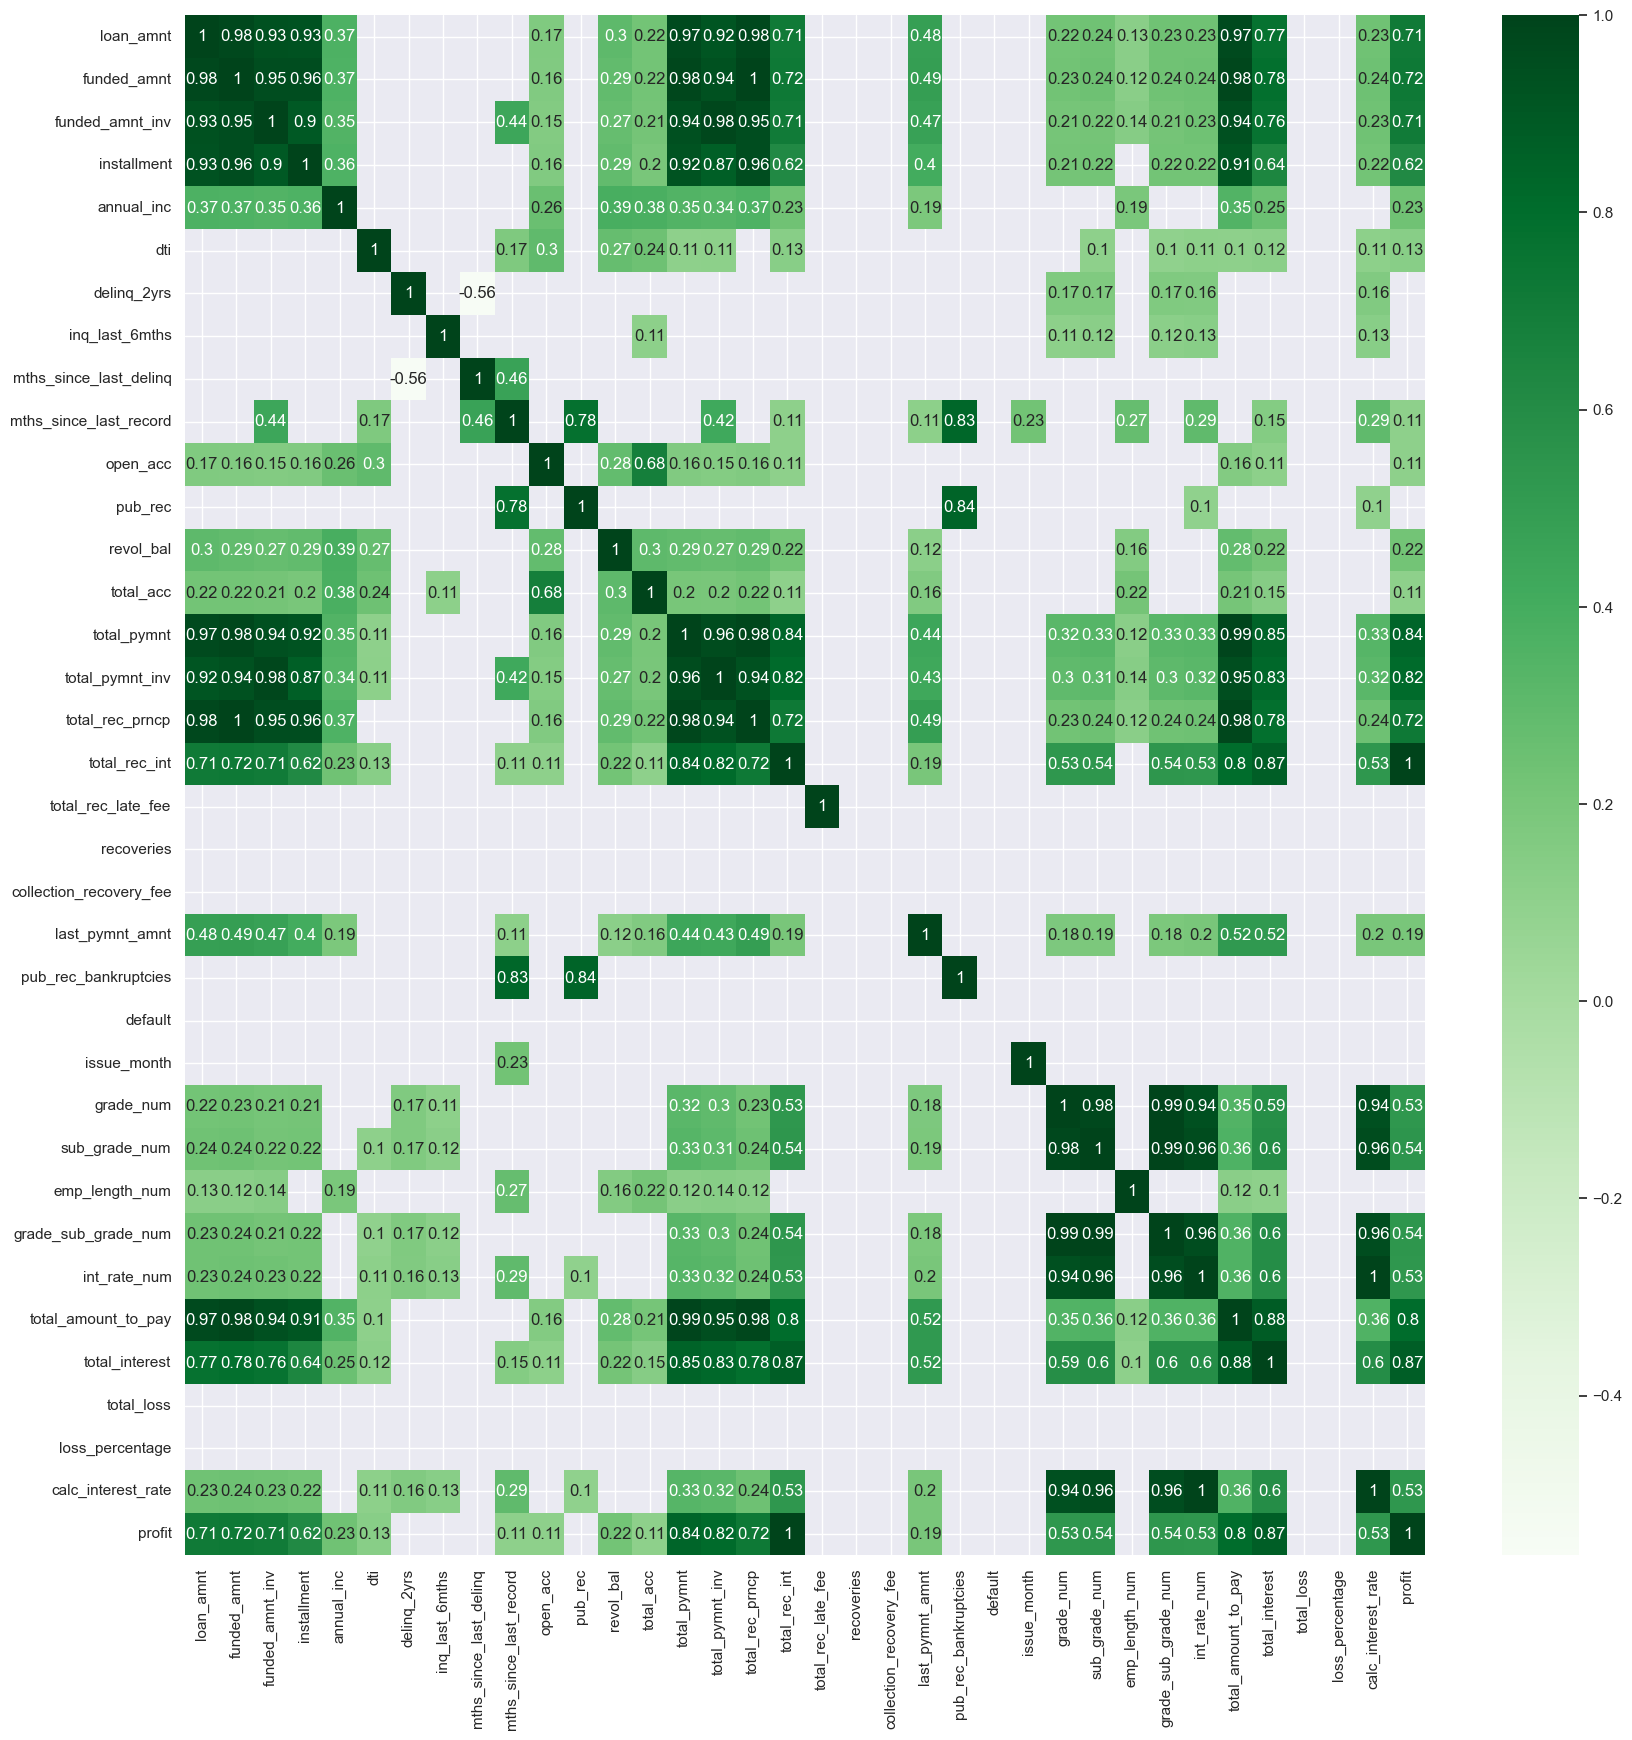

In [13]:
numerical_cols = loans[loans['loan_status'] == 'Fully Paid'].select_dtypes(include=[np.number])
print("Number of numerical columns: ", len(numerical_cols.columns))

cols_to_ignore = ['id', 'member_id', 'term_num', 'issue_year']

numerical_cols.drop(cols_to_ignore, axis=1, inplace=True)

corr_matrix = numerical_cols.corr()
# print(corr_matrix)

# plot correlation matrix
# Replace values below the threshold with NaN
threshold = 0.1
corr_matrix[abs(corr_matrix) < threshold] = np.nan
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Greens)
plt.show()

# Data analysis
Let us relation of default rate with different columns

### Default rate by year and months

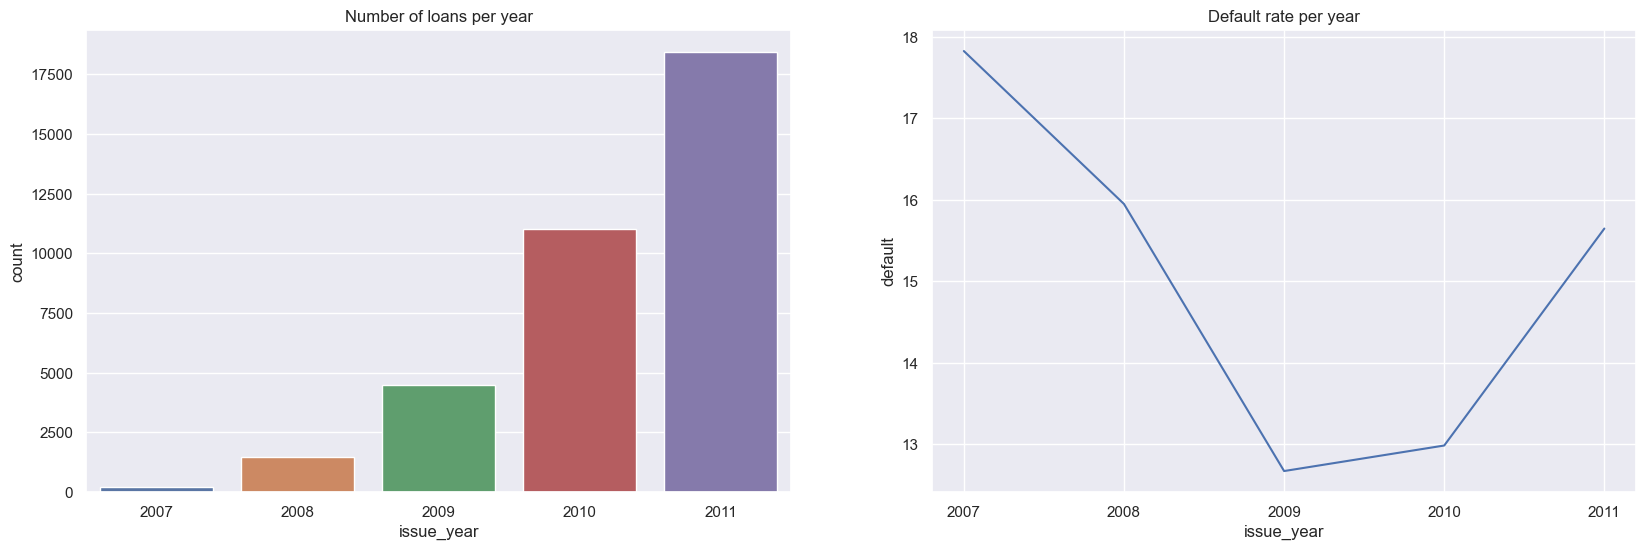

<Figure size 1200x600 with 0 Axes>

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# number of loans per year
sns.countplot(x='issue_year', data=loans, ax=ax1)
ax1.set_title('Number of loans per year')


# draw line chart of defaulted loans percentage per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_year', y='default', data=df, ax=ax2)
ax2.set_xticks(df['issue_year'])
ax2.set_title('Default rate per year')

plt.show()

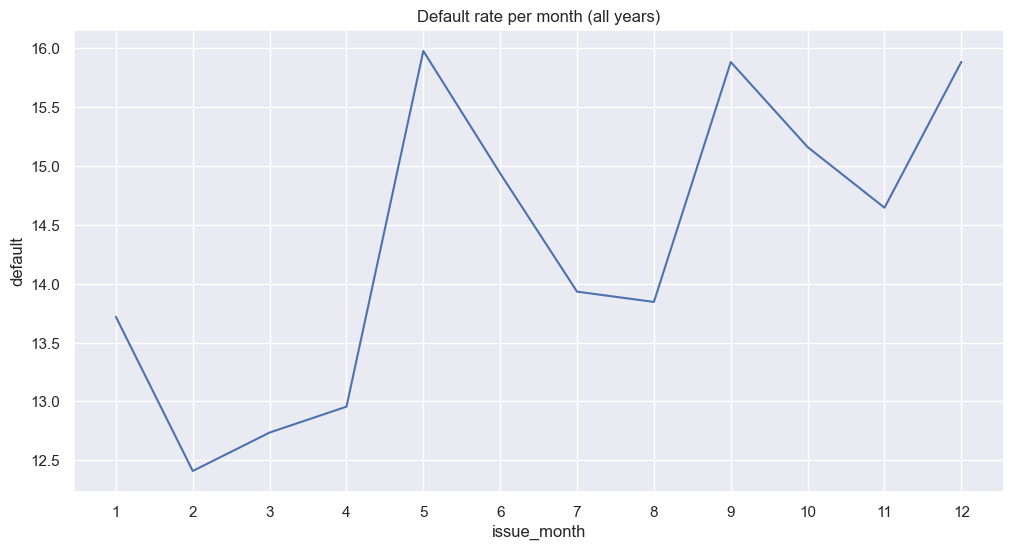

In [15]:
# draw line chart of defaulted loans percentage per month
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', data=df)
plt.xticks(df['issue_month'])
plt.title('Default rate per month (all years)')
plt.show()

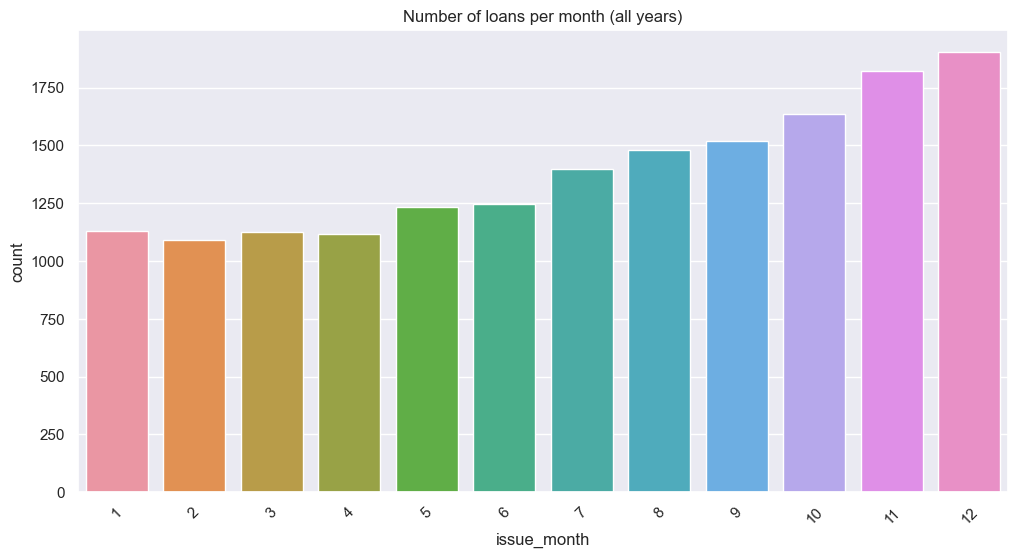

In [62]:
# plot number of loans per month
plt.figure(figsize=(12, 6))
sns.countplot(x='issue_month', data=loans[loans['purpose'] == 'debt_consolidation'])
plt.xticks(rotation=45)
plt.title('Number of loans per month (all years)')
plt.show()

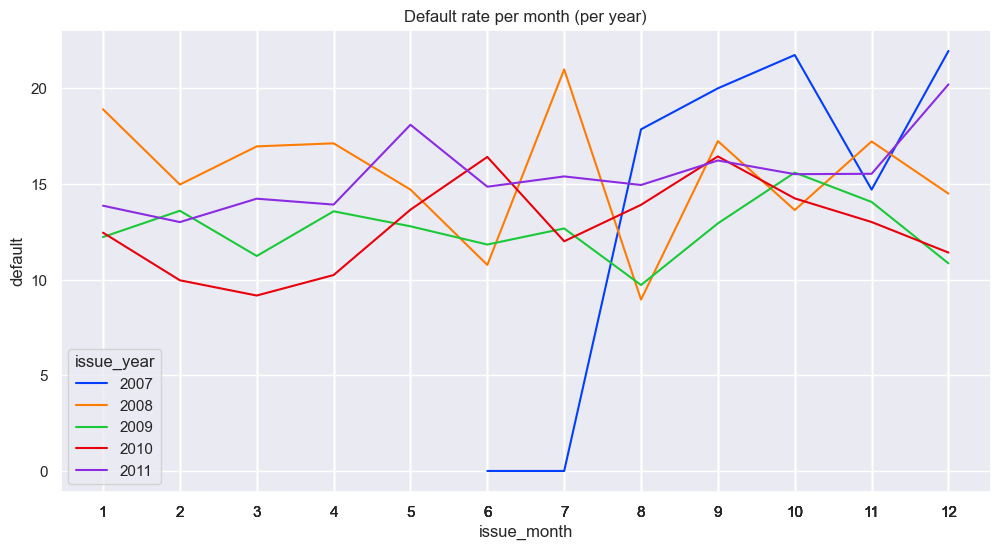

In [16]:
# draw line chart of defaulted loans percentage per month per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year', 'issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', hue='issue_year', data=df, palette='bright', legend='full')
plt.xticks(df['issue_month'])
plt.title('Default rate per month (per year)')
plt.show()

### Default rate by grade and subgrade

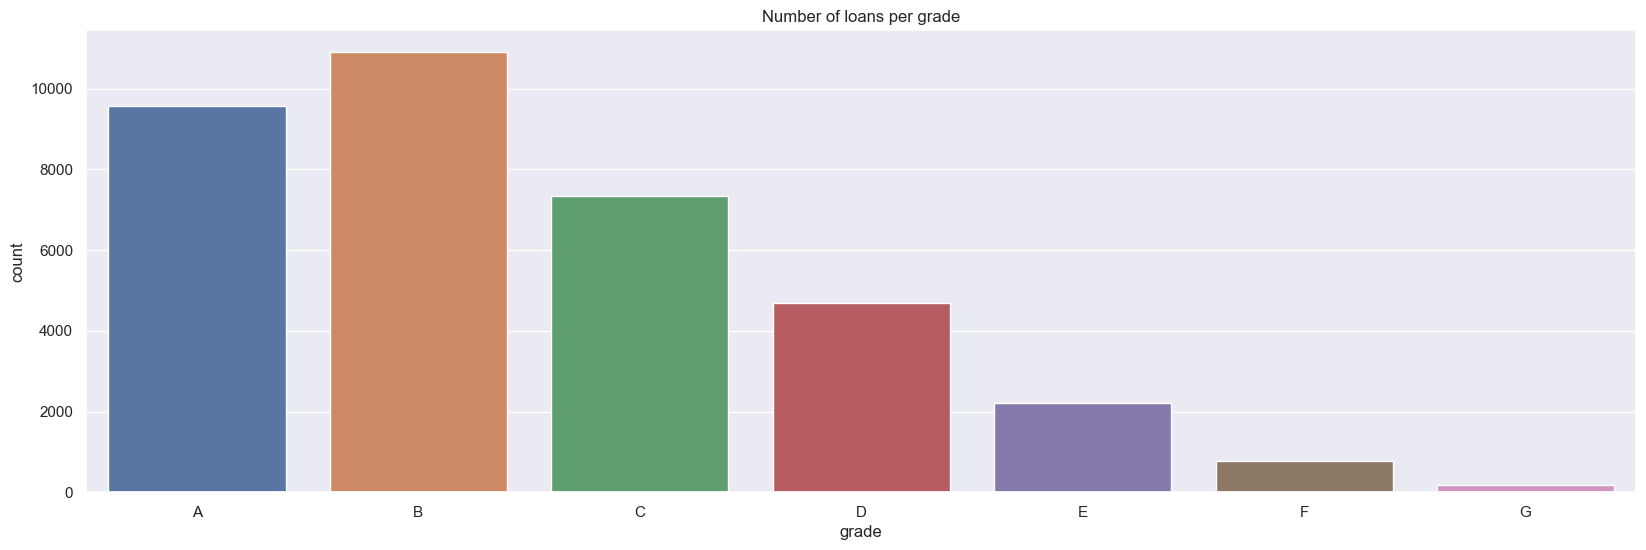

In [17]:
# plot number of loans per grade
plt.figure(figsize=(20, 6))
sns.countplot(x='grade', data=loans, order=sorted(loans['grade'].unique()))
plt.title('Number of loans per grade')
plt.show()

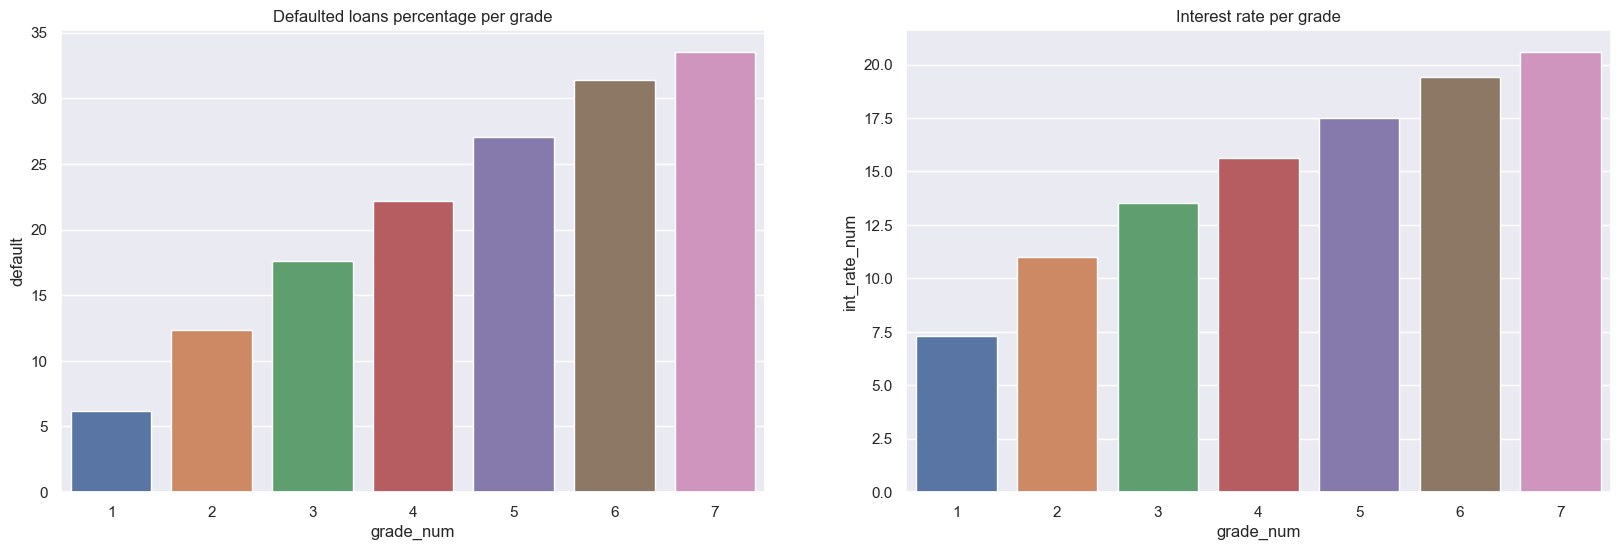

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw line chart of defaulted loans percentage per grade
default_rate = loans.groupby(['grade_num']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='grade_num', y='default', data=default_rate, ax=ax1)
ax1.set_title('Defaulted loans percentage per grade')

# draw interest rate per grade
interest_rate = loans.groupby(['grade_num']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='grade_num', y='int_rate_num', data=interest_rate, ax=ax2)
ax2.set_title('Interest rate per grade')

plt.show()

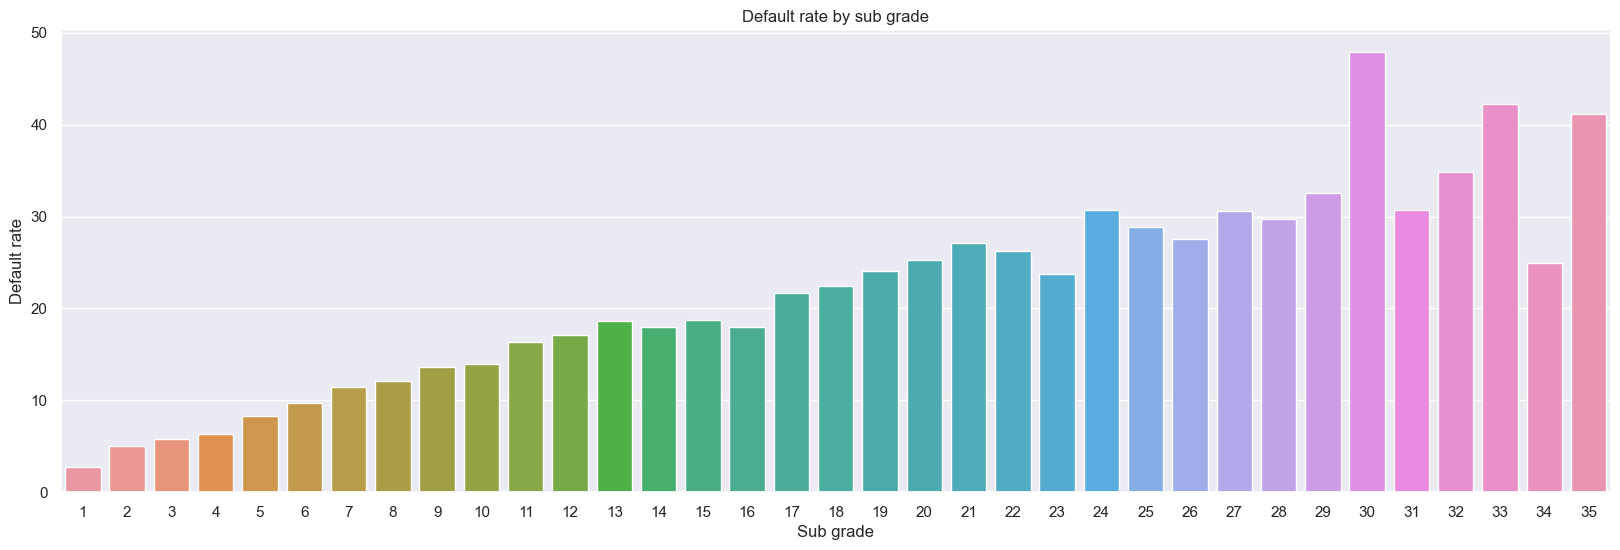

In [41]:
# plot default rate by sub_grade_num
plt.figure(figsize=(20, 6))
default_rate_sub_grade = loans[['sub_grade_num', 'default']].copy()
default_rate_sub_grade = default_rate_sub_grade.groupby(['sub_grade_num']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='sub_grade_num', y='default', data=default_rate_sub_grade)
plt.title('Default rate by sub grade')
plt.xlabel('Sub grade')
plt.ylabel('Default rate')
plt.show()

### Default rate by term size

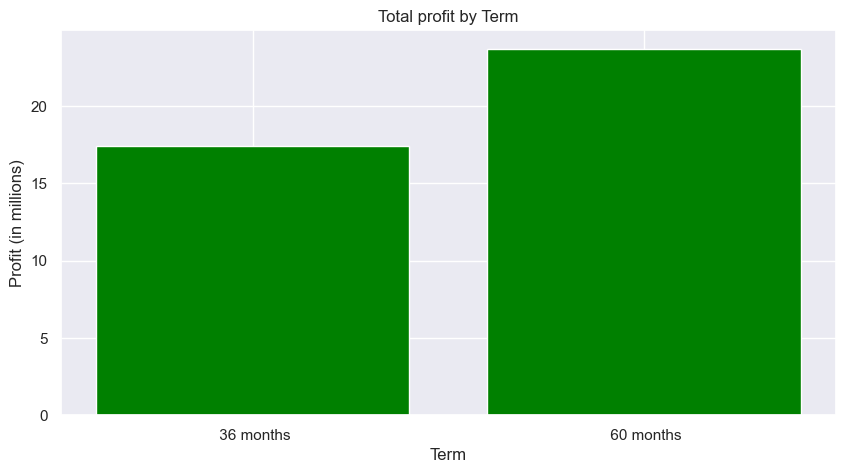

In [19]:
# plot total profit by term
profit_by_term = loans.groupby('term')['total_loss'].sum()
profit_by_term = profit_by_term.reset_index()
profit_by_term = profit_by_term.rename(columns={'total_loss': 'profit'})
profit_by_term['profit'] = profit_by_term['profit'].abs()
profit_by_term['profit'] = profit_by_term['profit'].apply(lambda x: x / 1000000)
profit_by_term['profit'] = profit_by_term['profit'].round(2)

# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(profit_by_term['term'], profit_by_term['profit'], color='green')
ax.set_title('Total profit by Term')
ax.set_xlabel('Term')
ax.set_ylabel('Profit (in millions)')
plt.show()

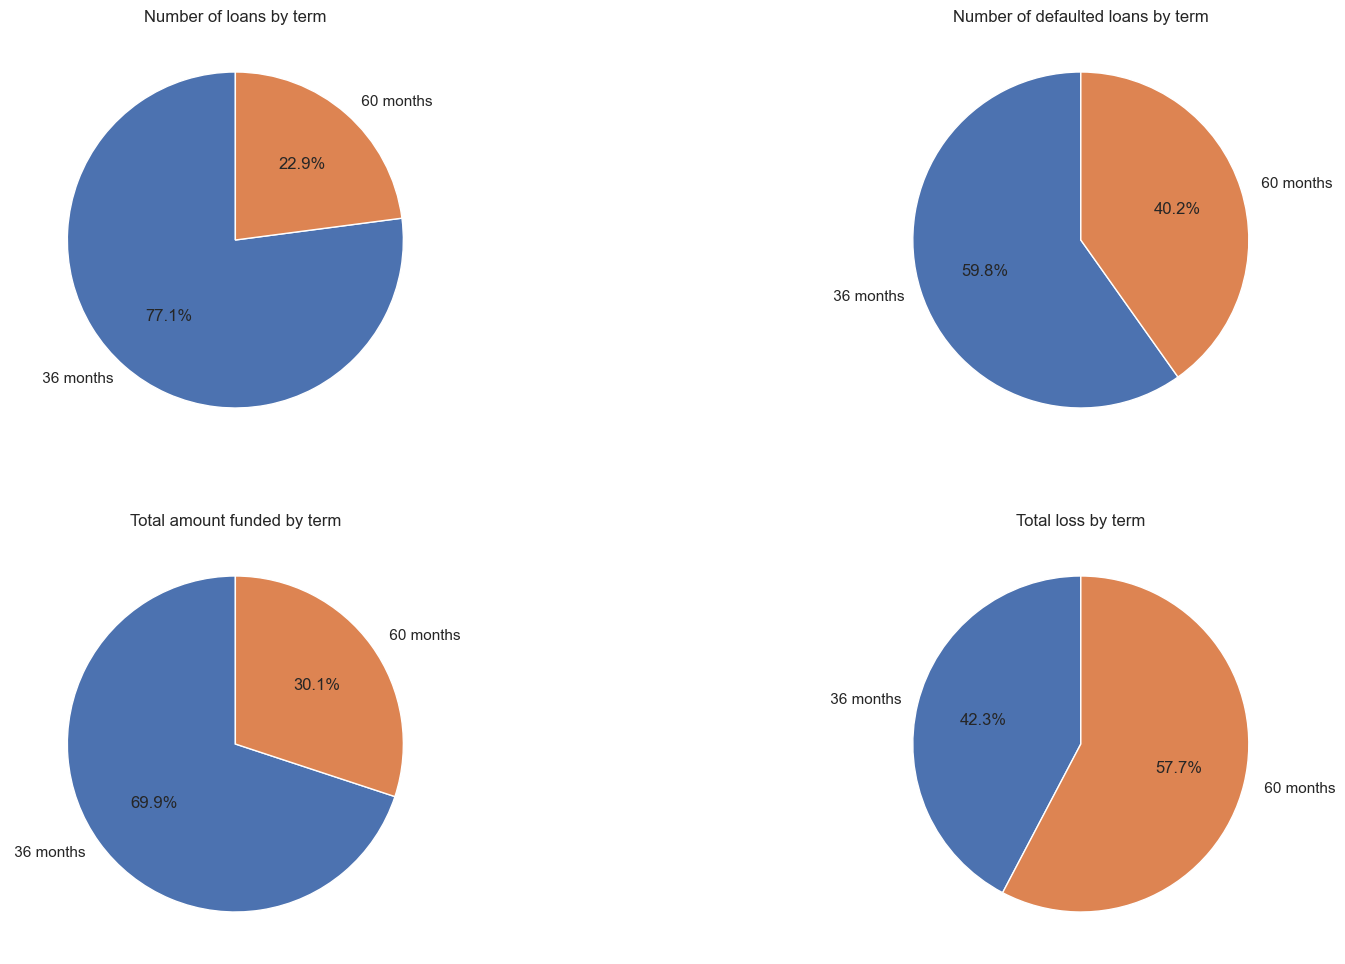

In [20]:
fig, plots = plt.subplots(2, 2, figsize=(20, 12))

# draw pie chart of number of loans by term
term = loans.groupby(['term']).agg({'id': 'count'}).reset_index()
plots[0, 0].pie(term['id'], labels=term['term'], autopct='%1.1f%%', startangle=90)
plots[0, 0].set_title('Number of loans by term')

# draw pie chart of number of defaulted loans by term
defaulted_loans = loans[loans['default'] != 0]
defaulted_loans = defaulted_loans.groupby(['term']).agg({'id': 'count'}).reset_index()
plots[0, 1].pie(defaulted_loans['id'], labels=defaulted_loans['term'], autopct='%1.1f%%', startangle=90)
plots[0, 1].set_title('Number of defaulted loans by term')

# total amount funded by term
total_amount_funded = loans.groupby(['term']).agg({'funded_amnt': 'sum'}).reset_index()
plots[1, 0].pie(total_amount_funded['funded_amnt'], labels=total_amount_funded['term'], autopct='%1.1f%%', startangle=90)
plots[1, 0].set_title('Total amount funded by term')

# total loss by term
total_loss = loans.groupby(['term']).agg({'total_loss': 'sum'}).reset_index()
total_loss['total_loss'] = total_loss['total_loss'].abs()
plots[1, 1].pie(total_loss['total_loss'], labels=total_loss['term'], autopct='%1.1f%%', startangle=90)
plots[1, 1].set_title('Total loss by term')

plt.show()

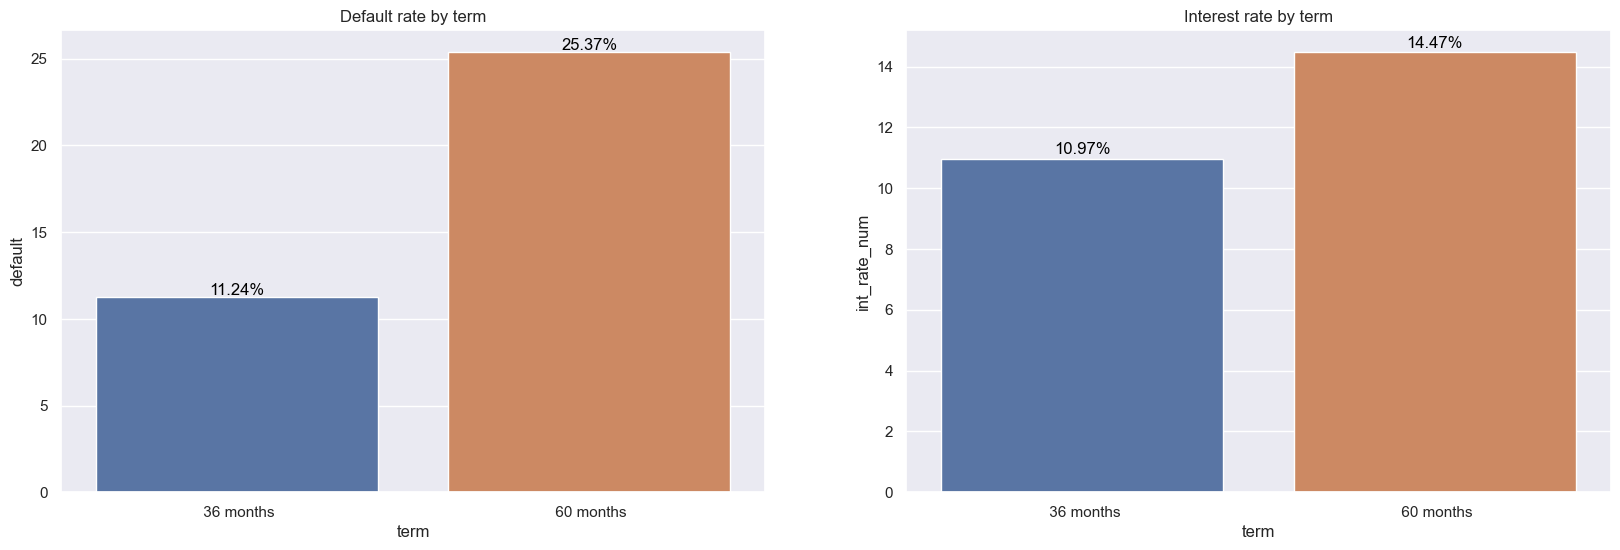

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# plot default rate by term
default_rate = loans.groupby(['term']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='term', y='default', data=default_rate, ax=ax1)

# show values on top of bars
for index, row in default_rate.iterrows():
    ax1.text(row.name, row.default + 0.15, str(round(row.default, 2)) + '%', color='black', ha="center")
ax1.set_title('Default rate by term')

# plot interest rate by term
interest_rate = loans.groupby(['term']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='term', y='int_rate_num', data=interest_rate, ax=ax2)

# show values on top of bars
for index, row in interest_rate.iterrows():
    ax2.text(row.name, row.int_rate_num + 0.15, str(round(row.int_rate_num, 2)) + '%', color='black', ha="center")
ax2.set_title('Interest rate by term')

plt.show()

### Default rate by purpose

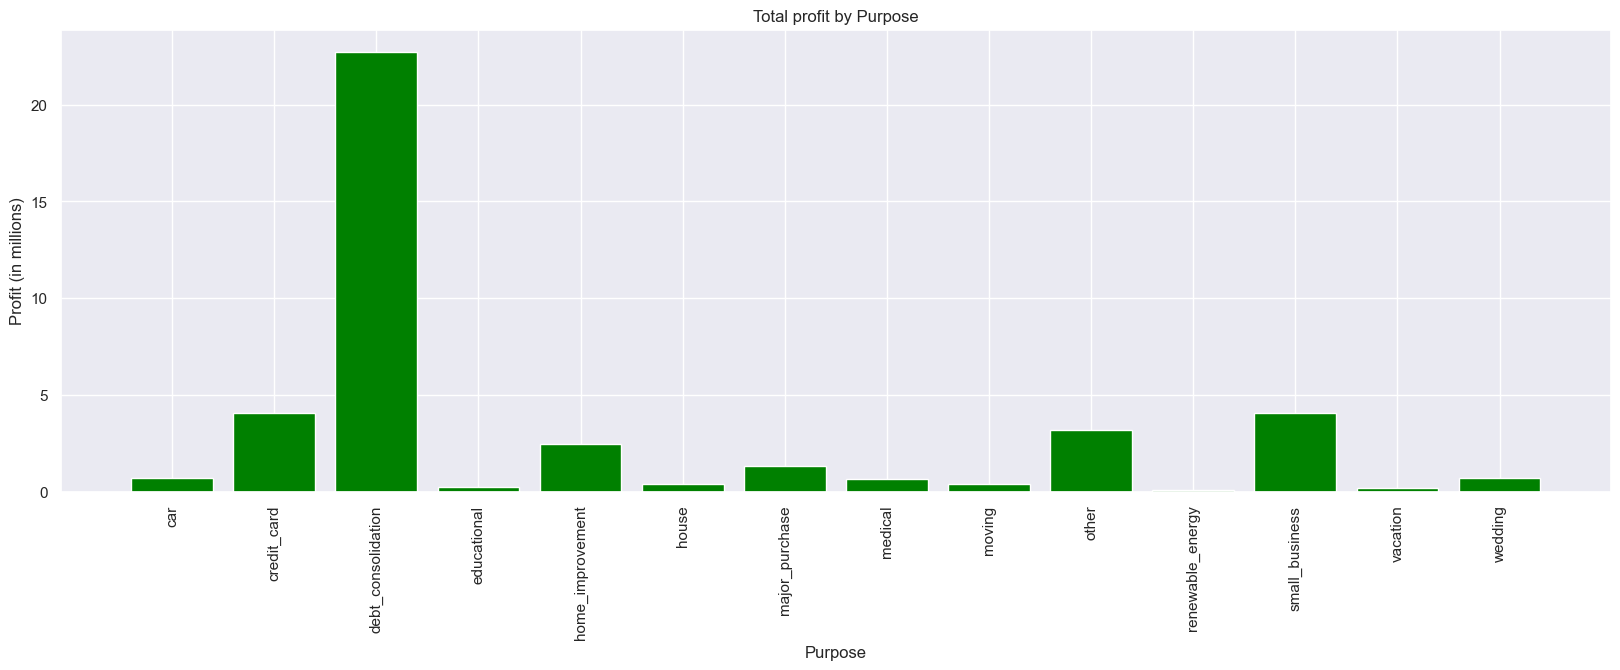

In [22]:
# plot profit by purpose
profit_by_purpose = loans.groupby('purpose')['total_loss'].sum()
profit_by_purpose = profit_by_purpose.reset_index()
profit_by_purpose = profit_by_purpose.rename(columns={'total_loss': 'profit'})
profit_by_purpose['profit'] = profit_by_purpose['profit'].abs()
profit_by_purpose['profit'] = profit_by_purpose['profit'].apply(lambda x: x / 1000000)
profit_by_purpose['profit'] = profit_by_purpose['profit'].round(2)

# plot
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(profit_by_purpose['purpose'], profit_by_purpose['profit'], color='green')
ax.set_title('Total profit by Purpose')
ax.set_xlabel('Purpose')
ax.set_ylabel('Profit (in millions)')
ax.set_xticks(range(len(profit_by_purpose['purpose'])))
ax.set_xticklabels(profit_by_purpose['purpose'], rotation=90)
plt.show()

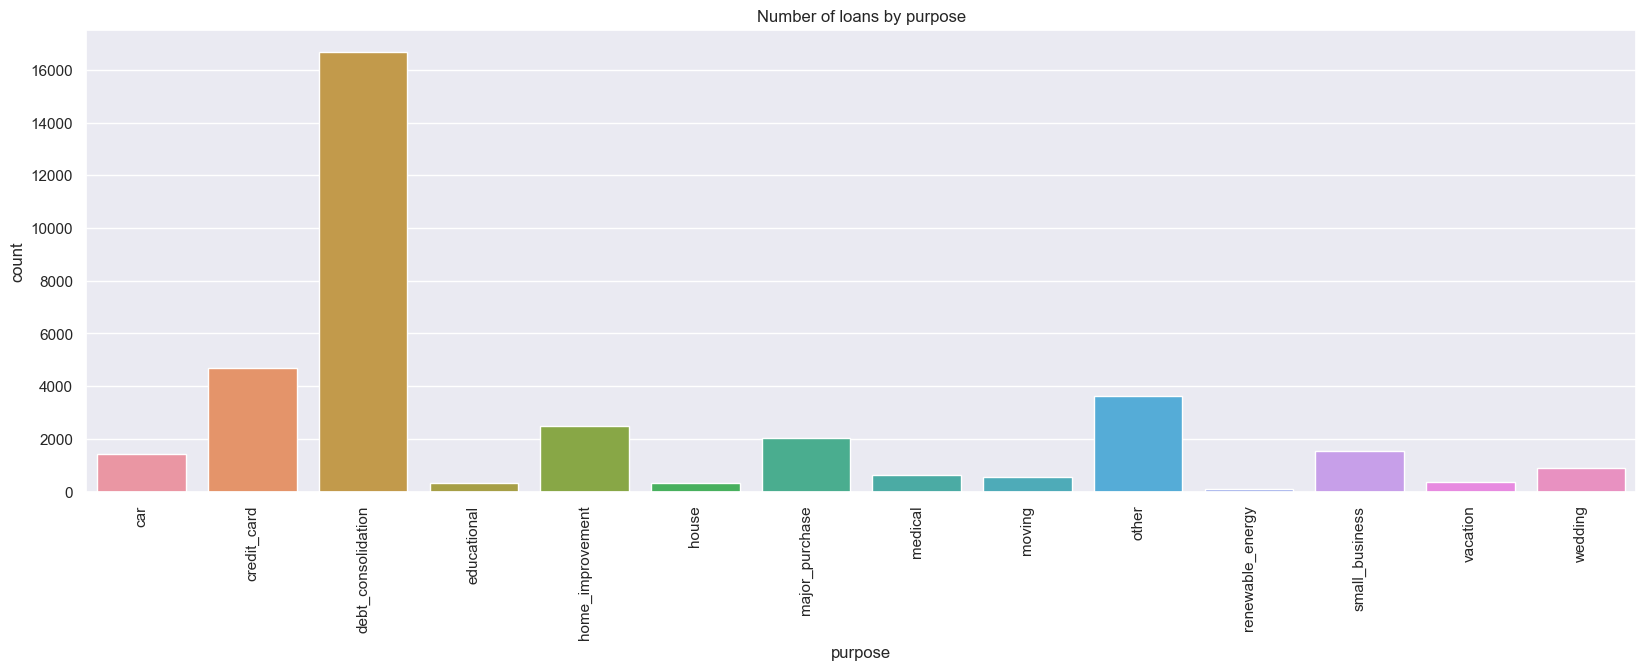

In [23]:
# plot number of loans by purpose
plt.figure(figsize=(20, 6))
sns.countplot(x='purpose', data=loans, order=sorted(loans['purpose'].unique()))
plt.title('Number of loans by purpose')
plt.xticks(rotation=90)
plt.show()

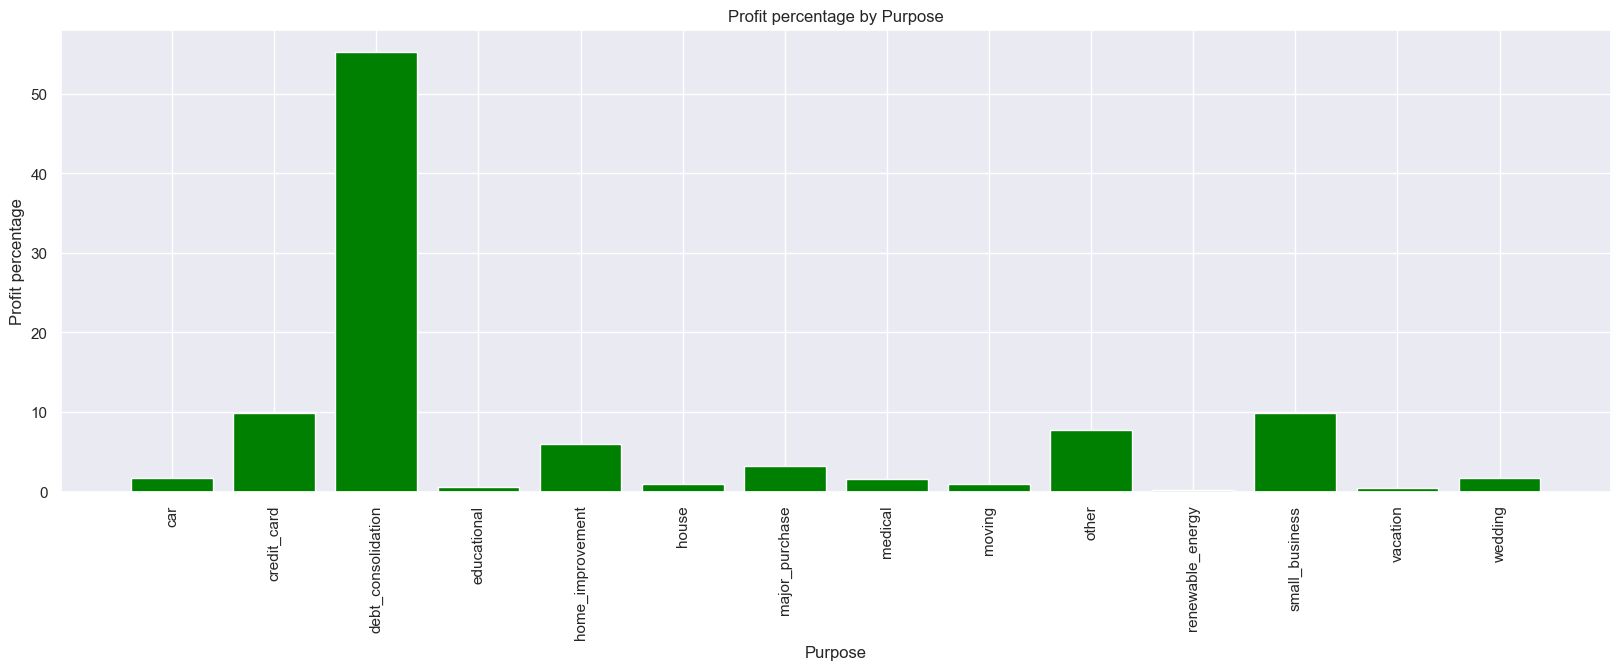

In [24]:
# profit percentage by purpose
profit_percentage_by_purpose = loans.groupby('purpose')['total_loss'].sum()
profit_percentage_by_purpose = profit_percentage_by_purpose.reset_index()
profit_percentage_by_purpose = profit_percentage_by_purpose.rename(columns={'total_loss': 'profit'})
profit_percentage_by_purpose['profit'] = profit_percentage_by_purpose['profit'].abs()
profit_percentage_by_purpose['profit'] = profit_percentage_by_purpose['profit'].apply(lambda x: x / 1000000)
profit_percentage_by_purpose['profit'] = profit_percentage_by_purpose['profit'].round(2)
profit_percentage_by_purpose['profit_percentage'] = profit_percentage_by_purpose['profit'] / profit_percentage_by_purpose['profit'].sum() * 100
profit_percentage_by_purpose['profit_percentage'] = profit_percentage_by_purpose['profit_percentage'].round(2)

# plot
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(profit_percentage_by_purpose['purpose'], profit_percentage_by_purpose['profit_percentage'], color='green')
ax.set_title('Profit percentage by Purpose')
ax.set_xlabel('Purpose')
ax.set_ylabel('Profit percentage')
ax.set_xticks(range(len(profit_percentage_by_purpose['purpose'])))
ax.set_xticklabels(profit_percentage_by_purpose['purpose'], rotation=90)
plt.show()

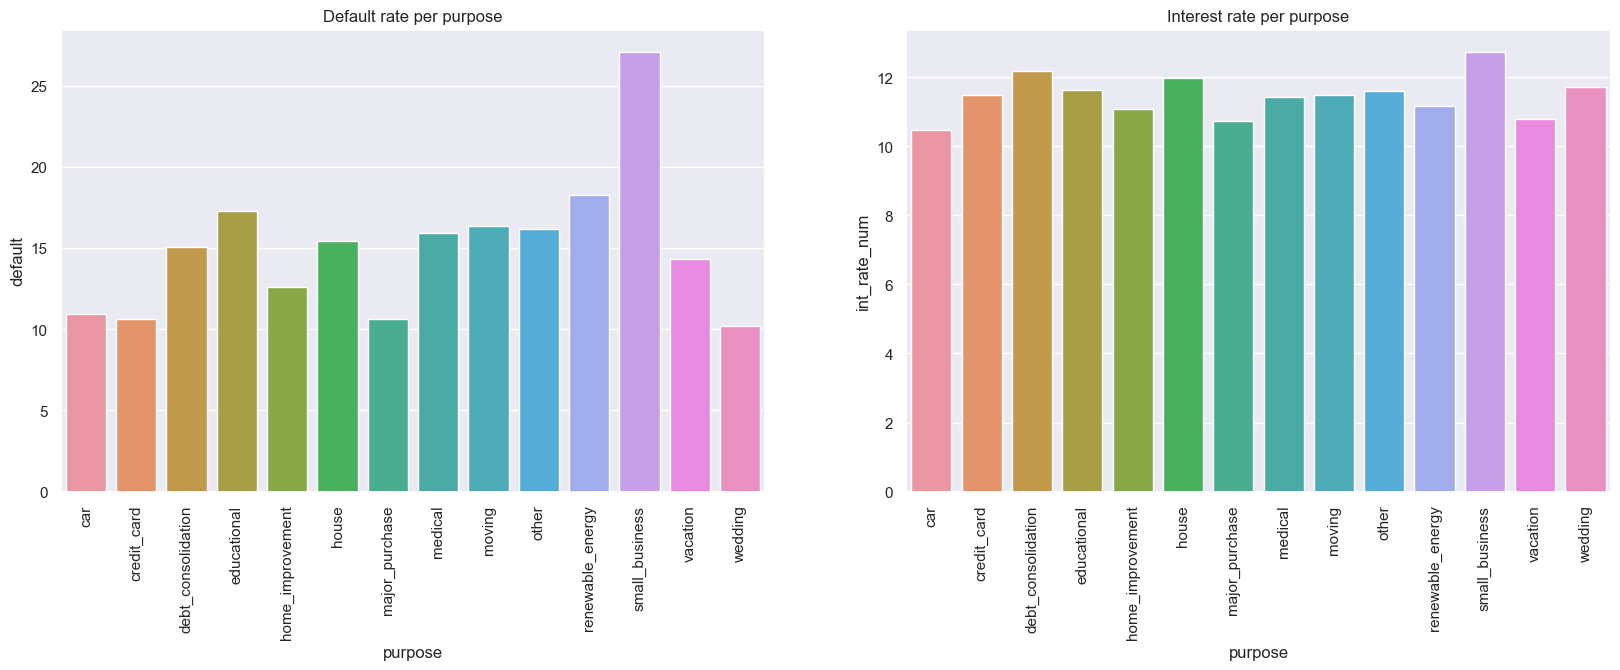

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw loan default percentage per purpose
default_rate = loans.groupby(['purpose']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='purpose', y='default', data=default_rate, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Default rate per purpose')

# draw interest rate per purpose
interest_rate = loans.groupby(['purpose']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='purpose', y='int_rate_num', data=interest_rate, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Interest rate per purpose')

plt.show()

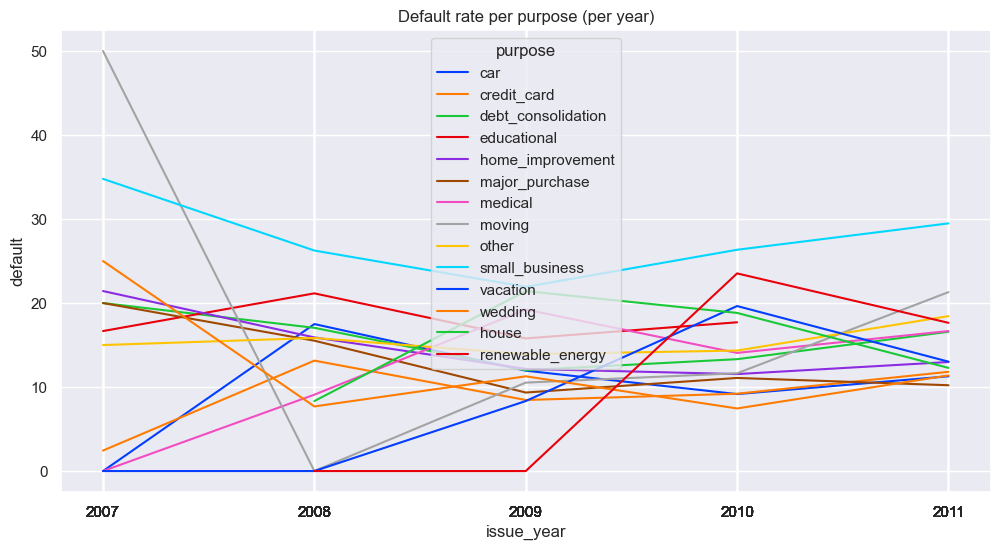

In [26]:
# plot heatmap of default rate by purpose per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year', 'purpose']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_year', y='default', hue='purpose', data=df, palette='bright', legend='full')
plt.xticks(df['issue_year'])
plt.title('Default rate per purpose (per year)')
plt.show()


### Default rate by home ownership

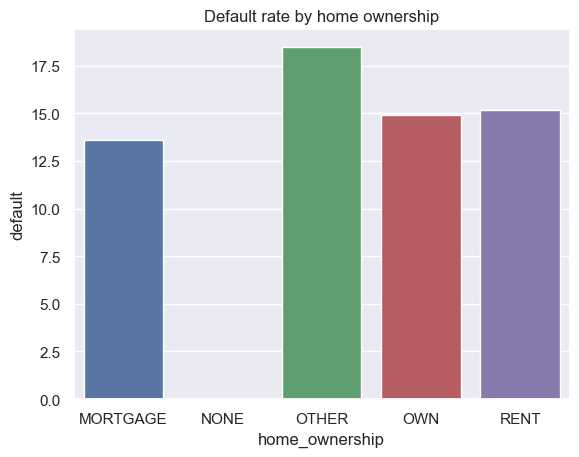

In [27]:
# plot default rate by home ownership
default_rate = loans.groupby(['home_ownership']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='home_ownership', y='default', data=default_rate)
plt.title('Default rate by home ownership')
plt.show()

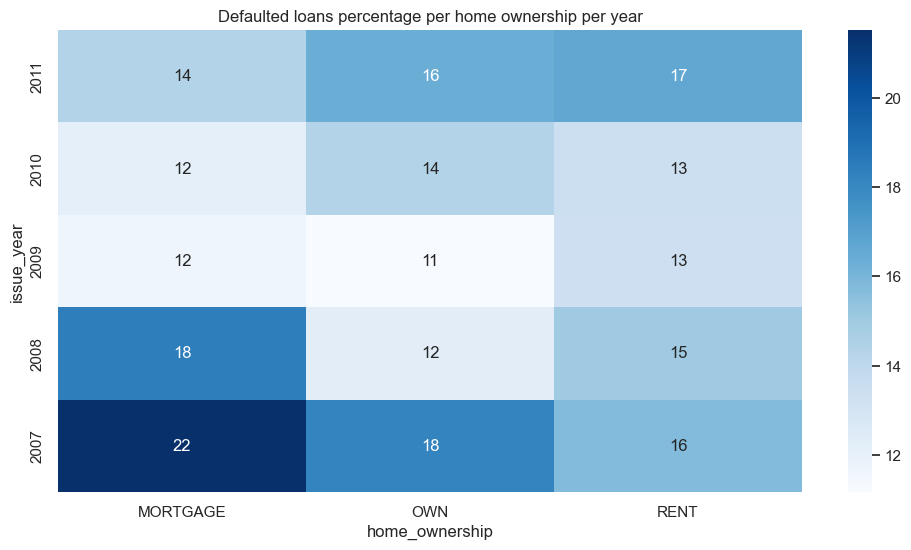

In [28]:
plt.figure(figsize=(12, 6))

df = loans.groupby(['issue_year', 'home_ownership']).agg({'default': 'mean'}).reset_index()

# ignore 'NONE' and 'OTHER' home ownership values as they are too few and do not provide any useful information
df = df[(df['home_ownership'] != 'NONE') & (df['home_ownership'] != 'OTHER')]

df = df.pivot(index='issue_year', columns='home_ownership', values='default')
df = df.sort_index(ascending=False)

sns.heatmap(df, annot=True, cmap='Blues', fmt='.2g')
plt.title('Defaulted loans percentage per home ownership per year')
plt.show()

### Default rate by income

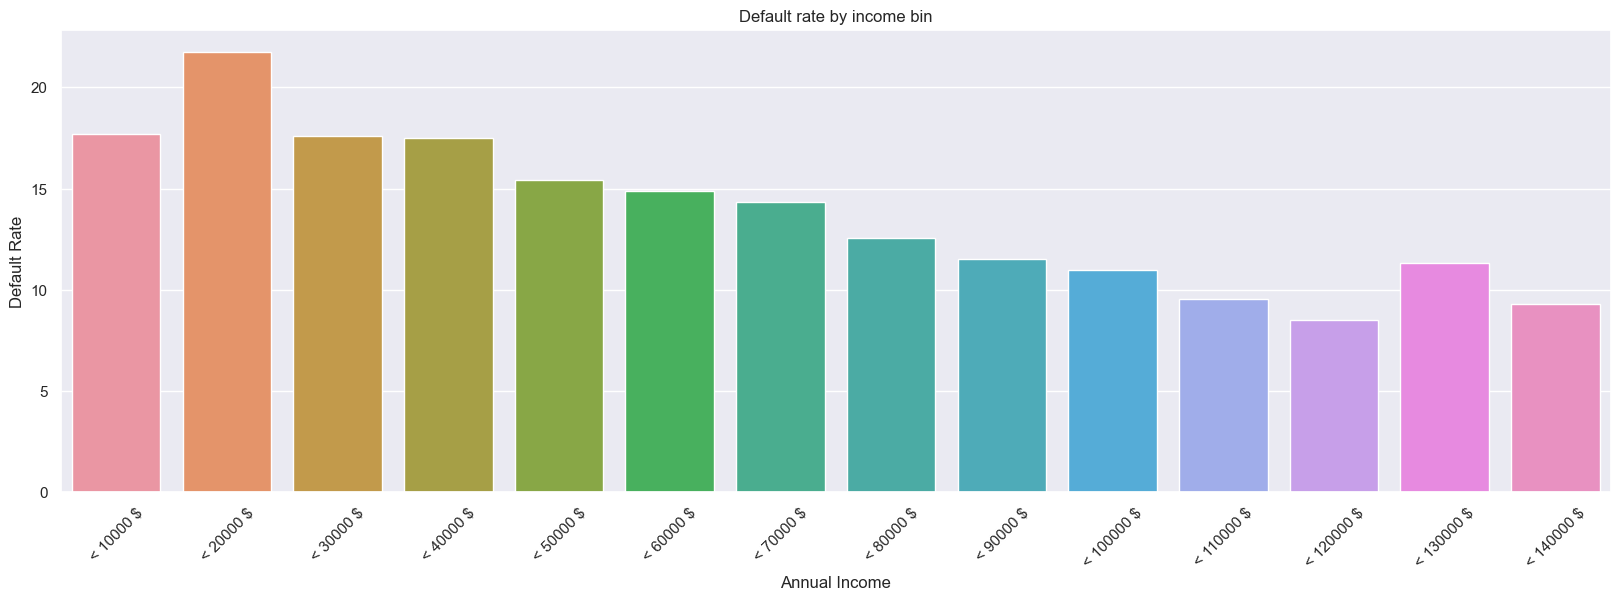

In [29]:
plt.figure(figsize=(20, 6))

# Copy the DataFrame to avoid SettingWithCopyWarning
default_rate_income = loans[['loan_status', 'annual_inc', 'default']].copy()

# Define user-friendly bin edges
bin_edges = range(0, int(default_rate_income['annual_inc'].max() + 10000), 10000)
default_rate_income['income_bin'] = pd.cut(default_rate_income['annual_inc'], bins=bin_edges, include_lowest=True, right=False)

default_rate_income = default_rate_income.groupby(['income_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='income_bin', y='default', data=default_rate_income)
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_income['income_bin']], rotation=45)
plt.xlabel('Annual Income')
plt.ylabel('Default Rate')
plt.title('Default rate by income bin')
plt.show()

### Default rate by state

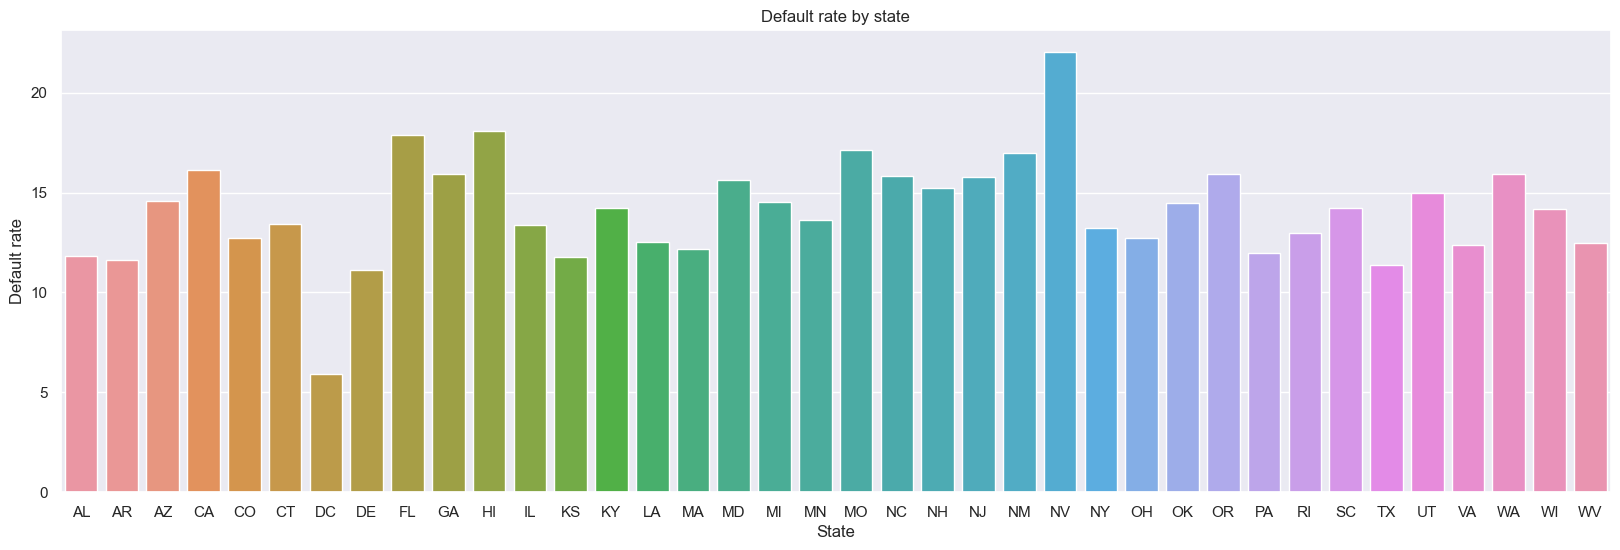

In [30]:
# show the default rate in each state
plt.figure(figsize=(20, 6))
default_rate_state = loans[['addr_state', 'default']].copy()

# ignore states that have less than 100 loans
default_rate_state = default_rate_state.groupby(['addr_state']).filter(lambda x: len(x) > 100)
default_rate_state = default_rate_state.groupby(['addr_state']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='addr_state', y='default', data=default_rate_state)
plt.title('Default rate by state')
plt.xlabel('State')
plt.ylabel('Default rate')
plt.show()

In [31]:
fig = px.choropleth(default_rate_state, locations='addr_state', color='default',
                    locationmode='USA-states', scope="usa",
                    title='Defaulters rate by State',
                    color_continuous_scale=px.colors.sequential.Reds,
                    labels={'percentage': 'Percentage of Defaulters'},
                    )
fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 10})
fig.show()

### Default rate by public records

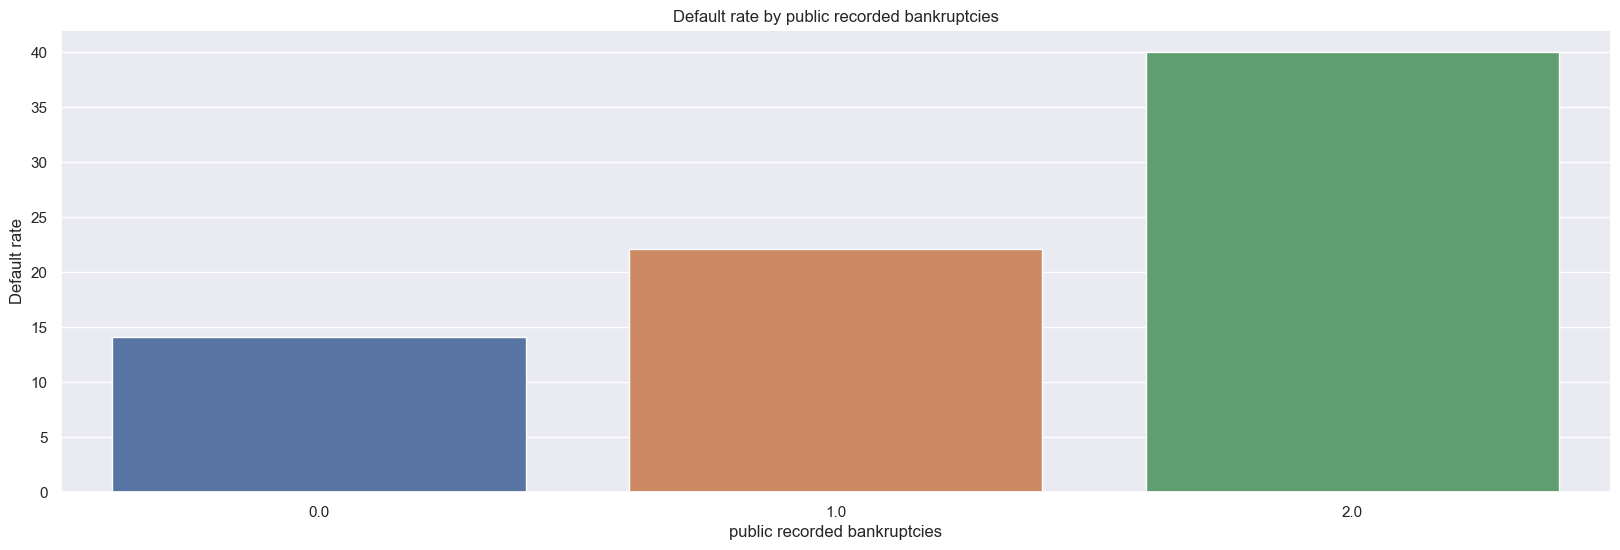

pub_rec_bankruptcies
0.0    33406
1.0     1567
2.0        5
Name: count, dtype: int64


In [47]:
# draw default by pub_rec_bankruptcies
plt.figure(figsize=(20, 6))
default_rate = loans.groupby(['pub_rec_bankruptcies']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='pub_rec_bankruptcies', y='default', data=default_rate)
plt.title('Default rate by public recorded bankruptcies')
plt.xlabel('public recorded bankruptcies')
plt.ylabel('Default rate')
plt.show()

print(loans['pub_rec_bankruptcies'].value_counts())

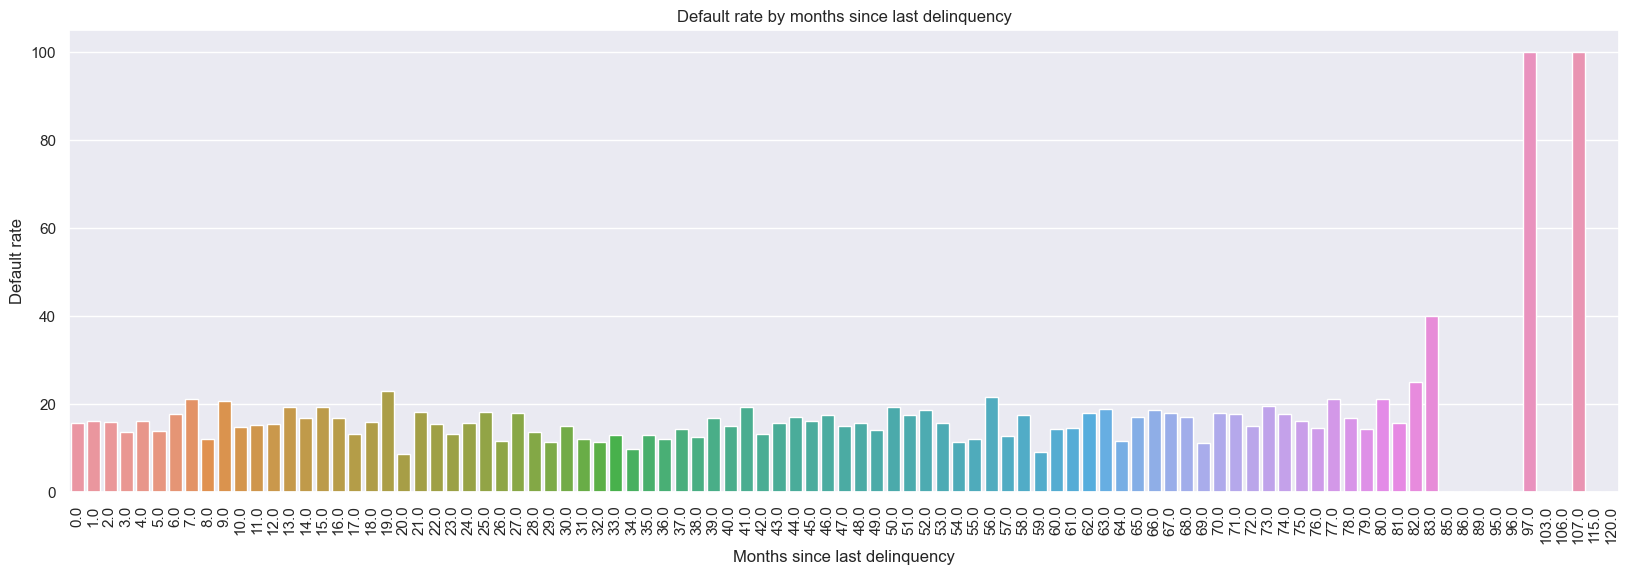

In [33]:
# draw default rate by mths_since_last_delinq (months since last delinquency) after binning
plt.figure(figsize=(20, 6))
default_rate = loans[['mths_since_last_delinq', 'default']].copy()

# bin the values
bin_edges = range(0, int(default_rate['mths_since_last_delinq'].max() + 12), 12)
default_rate['mths_since_last_delinq_bin'] = pd.cut(default_rate['mths_since_last_delinq'], bins=bin_edges, include_lowest=True, right=False)

default_rate = default_rate.groupby(['mths_since_last_delinq']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='mths_since_last_delinq', y='default', data=default_rate)
plt.title('Default rate by months since last delinquency')
plt.xticks(rotation=90)
plt.xlabel('Months since last delinquency')
plt.ylabel('Default rate')
plt.show()

mths_since_last_record
0.0      632
5.0        1
6.0        1
7.0        1
11.0       2
        ... 
117.0     42
118.0     34
119.0      9
120.0      1
129.0      1
Name: count, Length: 110, dtype: int64


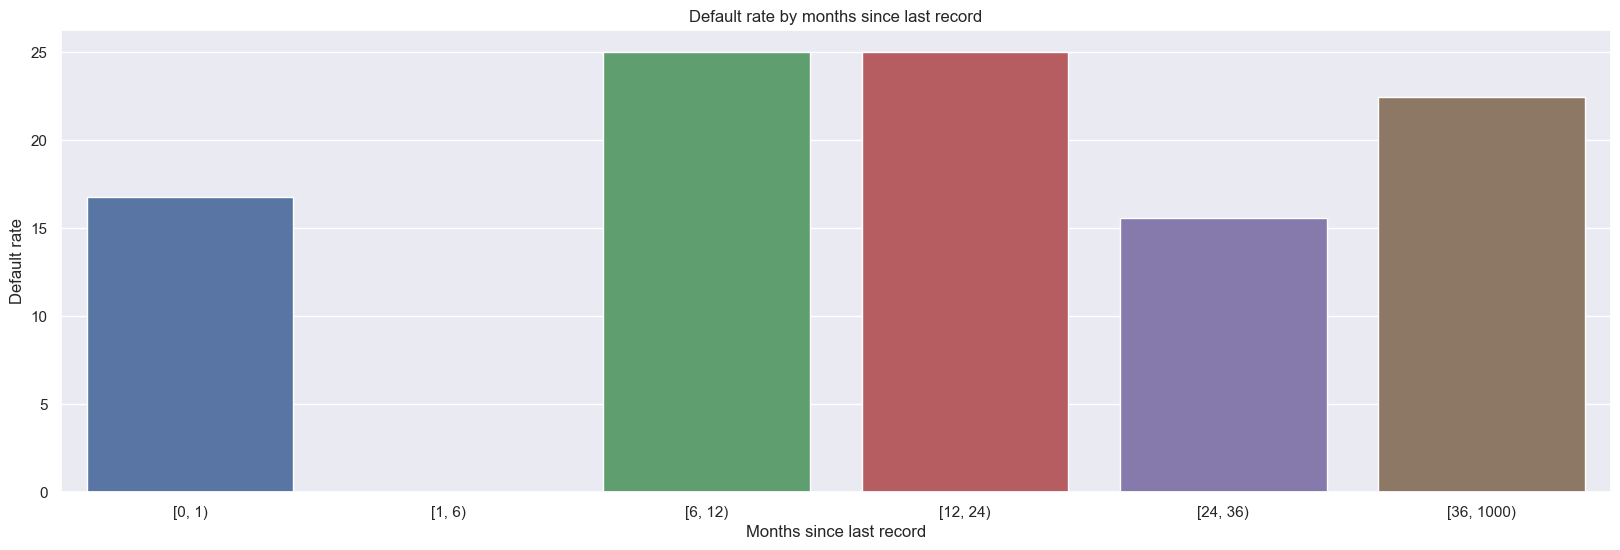

In [34]:
print(loans['mths_since_last_record'].value_counts().sort_index())
# draw default rate by mths_since_last_record (months since last record) after binning
plt.figure(figsize=(20, 6))
default_rate = loans[['mths_since_last_record', 'default']].copy()

# bin mths_since_last_record for 0 months, till last 6 months and more than 6 months
default_rate['mths_since_last_record_bin'] = pd.cut(default_rate['mths_since_last_record'], bins=[0, 1, 6, 12, 24, 36, 1000], include_lowest=True, right=False)

default_rate = default_rate.groupby(['mths_since_last_record_bin']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='mths_since_last_record_bin', y='default', data=default_rate)
plt.title('Default rate by months since last record')
plt.xlabel('Months since last record')
plt.ylabel('Default rate')
plt.show()

### Default rate by interest rate

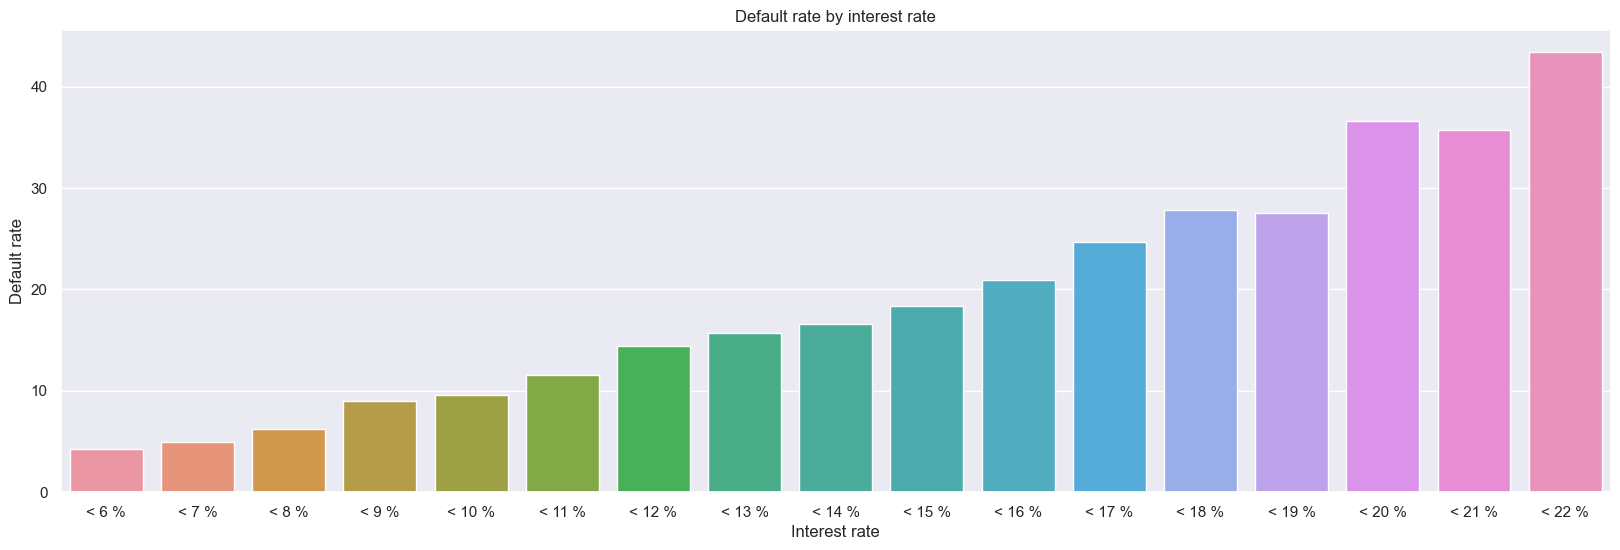

In [35]:
# draw default by binned interest rate
plt.figure(figsize=(20, 6))
default_rate_interest = loans[['int_rate_num', 'default']].copy()
# bin interest rate using intervals of 1% on column 'int_rate_num'
bin_edges = range(int(default_rate_interest['int_rate_num'].min()), int(default_rate_interest['int_rate_num'].max() + 1), 1)
default_rate_interest['int_rate_bin'] = pd.cut(default_rate_interest['int_rate_num'], bins=bin_edges, include_lowest=True, right=False)
default_rate_interest = default_rate_interest.groupby(['int_rate_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='int_rate_bin', y='default', data=default_rate_interest)
plt.title('Default rate by interest rate')
plt.xlabel('Interest rate')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_interest['int_rate_bin']])
plt.ylabel('Default rate')
plt.show()

### Default rate by loan amount

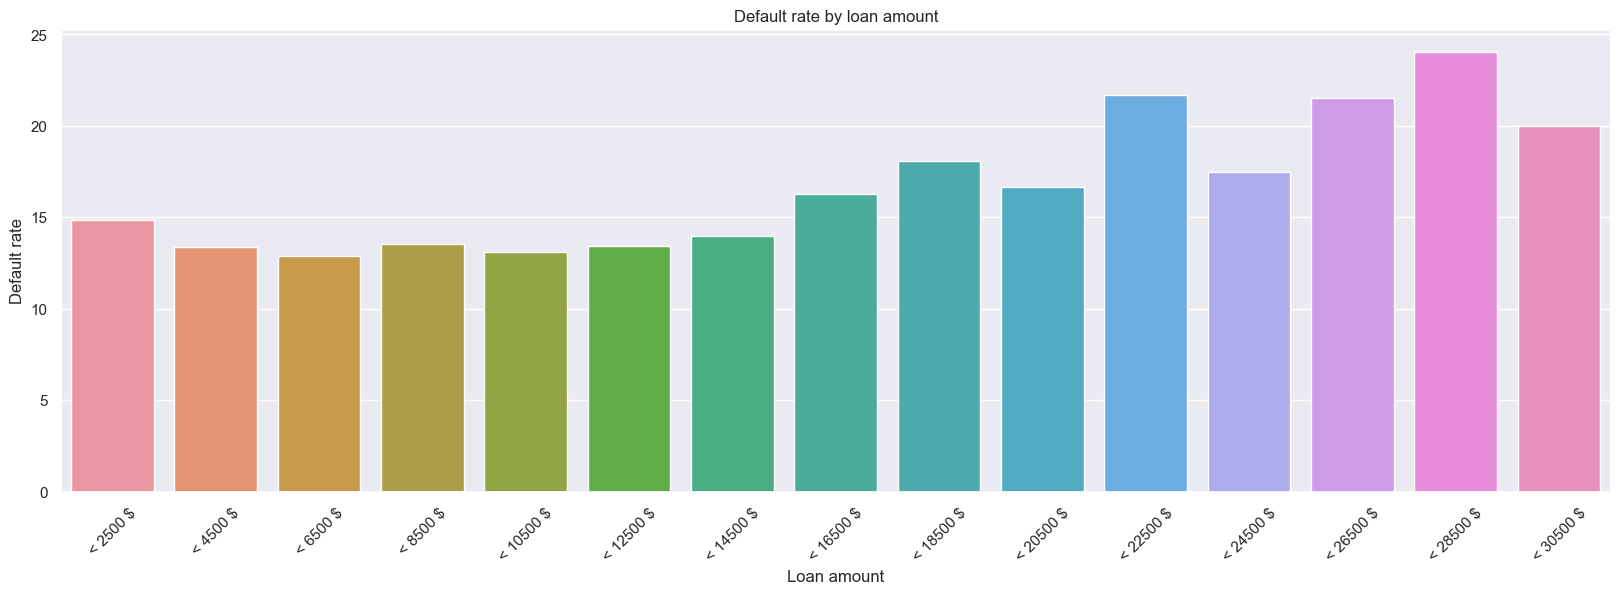

In [46]:
# plot default rate by binned loan amount
plt.figure(figsize=(20, 6))
default_rate_loan_amount = loans[['loan_amnt', 'default']].copy()
# bin loan amount using intervals of 2000 on column 'loan_amnt'
bin_size = 2000
bin_edges = range(int(default_rate_loan_amount['loan_amnt'].min()), int(default_rate_loan_amount['loan_amnt'].max() + bin_size), bin_size)
default_rate_loan_amount['loan_amnt_bin'] = pd.cut(default_rate_loan_amount['loan_amnt'], bins=bin_edges, include_lowest=True, right=False)
default_rate_loan_amount = default_rate_loan_amount.groupby(['loan_amnt_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='loan_amnt_bin', y='default', data=default_rate_loan_amount)
plt.title('Default rate by loan amount')
plt.xlabel('Loan amount')
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_loan_amount['loan_amnt_bin']], rotation=45)
plt.ylabel('Default rate')
plt.show()

In [36]:
# show value counts for all categorical columns
for col in loans.select_dtypes(include=['object']).columns:
    print(loans[col].value_counts())

term
 36 months    27465
 60 months     8170
Name: count, dtype: int64
int_rate
10.99%    842
7.51%     764
11.49%    746
7.88%     702
13.49%    681
         ... 
16.96%      1
17.44%      1
16.01%      1
18.36%      1
15.01%      1
Name: count, Length: 357, dtype: int64
grade
B    10902
A     9568
C     7329
D     4689
E     2204
F      764
G      179
Name: count, dtype: int64
sub_grade
A4    2708
B3    2593
A5    2576
B5    2440
B4    2290
C1    1920
B2    1884
C2    1793
A3    1744
B1    1695
A2    1443
C3    1397
D2    1194
C4    1150
A1    1097
C5    1069
D3    1033
D1     876
D4     835
D5     751
E1     609
E2     518
E3     434
E4     355
E5     288
F1     239
F2     193
F3     138
F4     123
F5      71
G1      65
G2      43
G4      28
G3      26
G5      17
Name: count, dtype: int64
emp_title
US Army                                  118
Bank of America                          104
AT&T                                      54
US Air Force                              50
IBM    

In [37]:
print(loans['title'].describe())
df = loans
df['title'] = df['title'].fillna('')
df['title'] = df['title'].astype('str')
# find all rows with credit history in title
def find_credit_history_in_title(row):
    if 'consolidation' in row['title'].lower():
        return row['title']
    else:
        return np.nan

credit_history_in_title  = df.apply(find_credit_history_in_title, axis=1)
credit_history_in_title.value_counts()

count                  35624
unique                 18176
top       Debt Consolidation
freq                    1872
Name: title, dtype: object


Debt Consolidation                          1872
Debt Consolidation Loan                     1428
Consolidation                                435
debt consolidation                           429
Credit Card Consolidation                    332
                                            ... 
John Deer consolidation                        1
Credit Card Consolidation - From College       1
consolidation2011                              1
2 morgage consolidation                        1
MBA Loan Consolidation                         1
Name: count, Length: 1305, dtype: int64

### Default rate by debt to income ratio

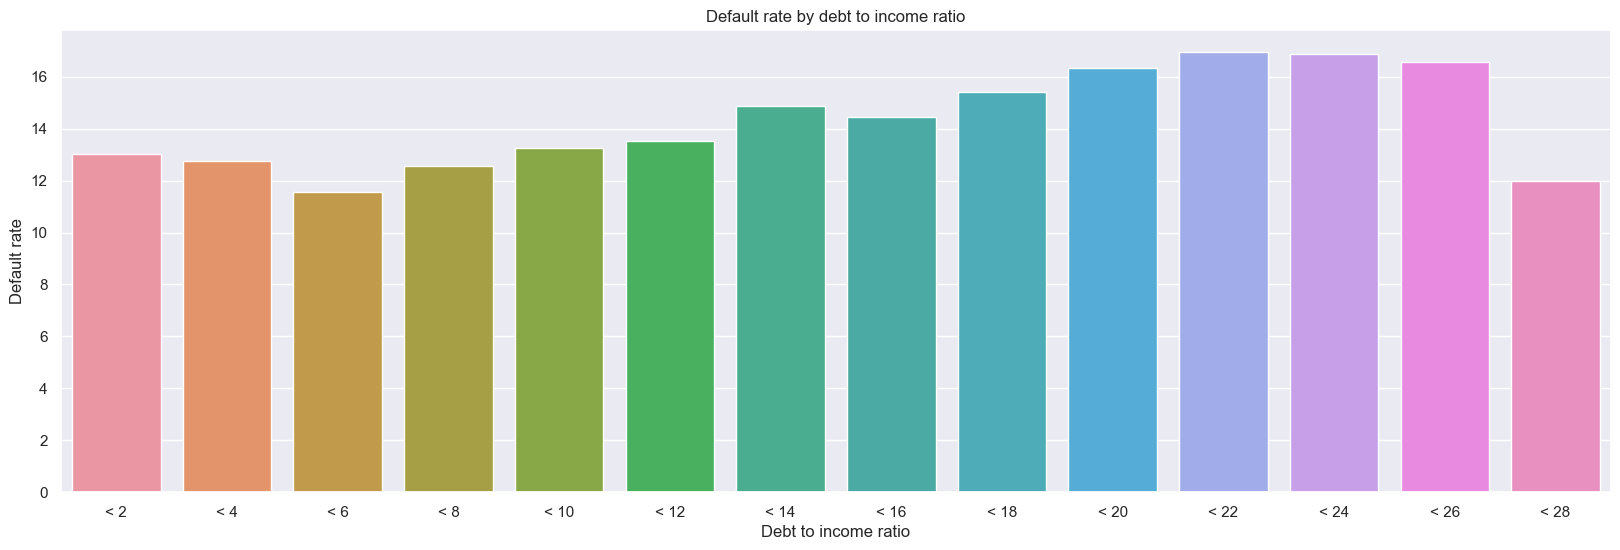

In [38]:
# plot default rate by dti
plt.figure(figsize=(20, 6))
default_rate_dti = loans[['dti', 'default']].copy()
# bin dti using intervals of 5 on column 'dti'
bin_edges = range(int(default_rate_dti['dti'].min()), int(default_rate_dti['dti'].max() + 1), 2)
default_rate_dti['dti_bin'] = pd.cut(default_rate_dti['dti'], bins=bin_edges, include_lowest=True, right=False)
default_rate_dti = default_rate_dti.groupby(['dti_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='dti_bin', y='default', data=default_rate_dti)
plt.title('Default rate by debt to income ratio')
plt.xlabel('Debt to income ratio')
bar_plot.set_xticklabels([f"< {str(interval.right)}" for interval in default_rate_dti['dti_bin']])
plt.ylabel('Default rate')
plt.show()

### Default rate by employment length

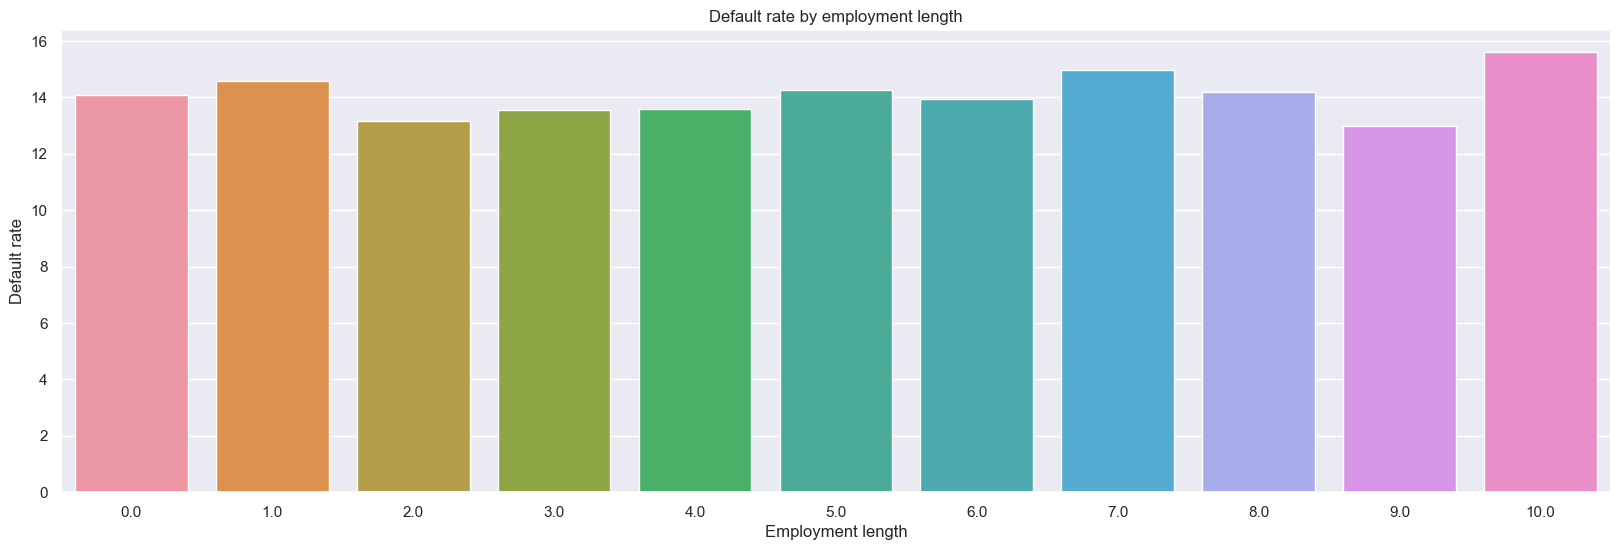

In [39]:
# plot default rate by emp_length_num
plt.figure(figsize=(20, 6))
default_rate_emp_length = loans[['emp_length_num', 'default']].copy()
default_rate_emp_length = default_rate_emp_length.groupby(['emp_length_num']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='emp_length_num', y='default', data=default_rate_emp_length)
plt.title('Default rate by employment length')
plt.xlabel('Employment length')
plt.ylabel('Default rate')
plt.show()

### Default rate by verification status

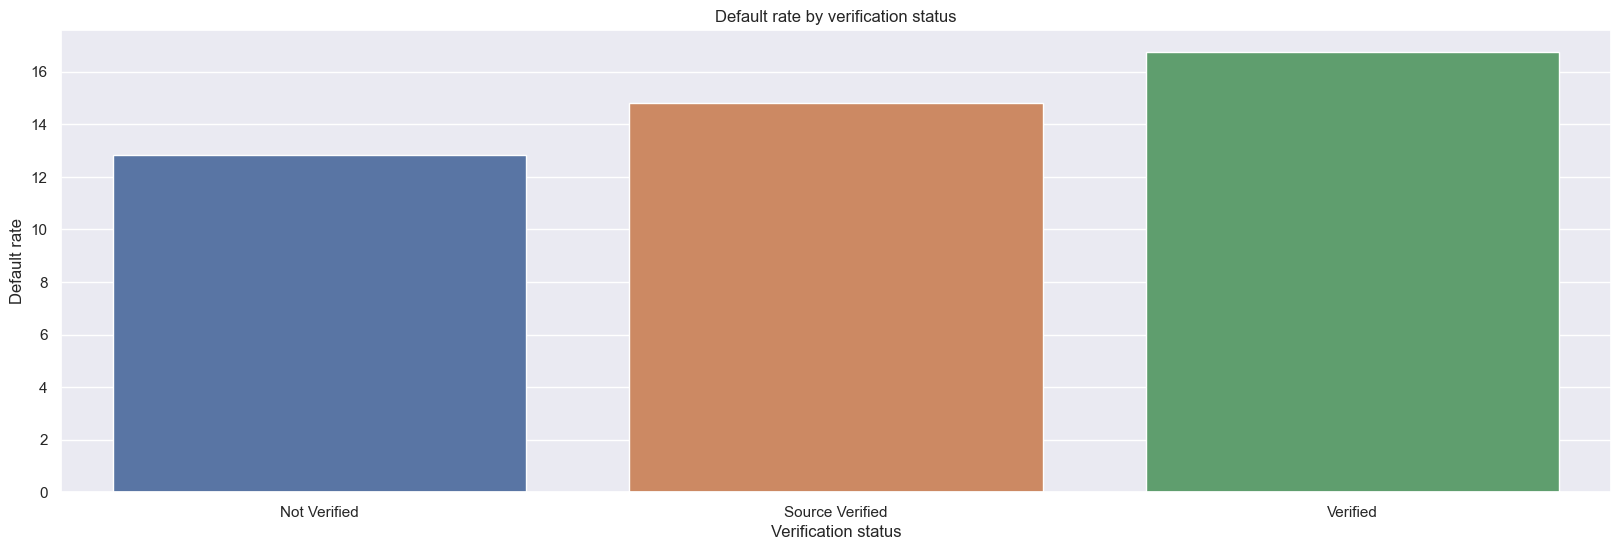

In [40]:
# plot default rate by verification_status
plt.figure(figsize=(20, 6))
default_rate_verification_status = loans[['verification_status', 'default']].copy()
default_rate_verification_status = default_rate_verification_status.groupby(['verification_status']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='verification_status', y='default', data=default_rate_verification_status)
plt.title('Default rate by verification status')
plt.xlabel('Verification status')
plt.ylabel('Default rate')
plt.show()

### Default rate by installment size

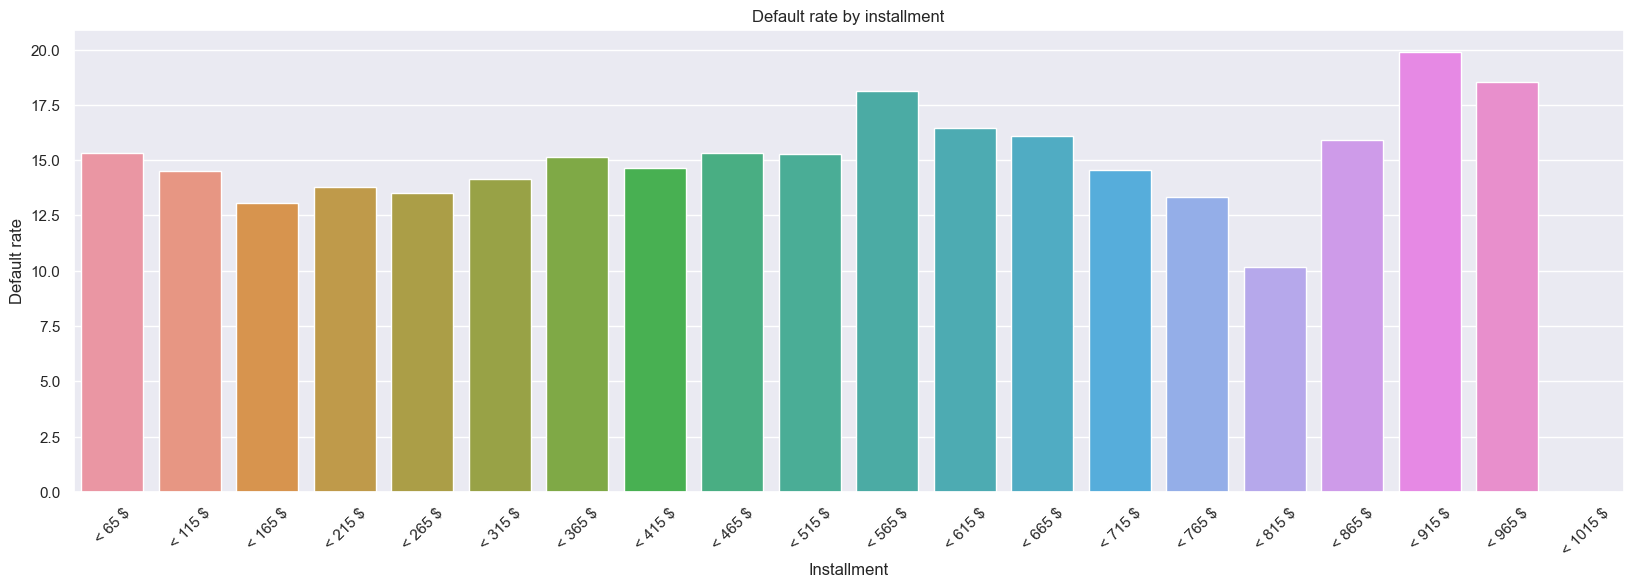

In [48]:
# plot default rate by installment
plt.figure(figsize=(20, 6))
default_rate_installment = loans[['installment', 'default']].copy()
# bin installment using intervals of 50 on column 'installment'
bin_size = 50
bin_edges = range(int(default_rate_installment['installment'].min()), int(default_rate_installment['installment'].max() + bin_size), bin_size)
default_rate_installment['installment_bin'] = pd.cut(default_rate_installment['installment'], bins=bin_edges, include_lowest=True, right=False)
default_rate_installment = default_rate_installment.groupby(['installment_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='installment_bin', y='default', data=default_rate_installment)
plt.title('Default rate by installment')
plt.xlabel('Installment')
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_installment['installment_bin']], rotation=45)
plt.ylabel('Default rate')
plt.show()

### Default rate by open credit lines

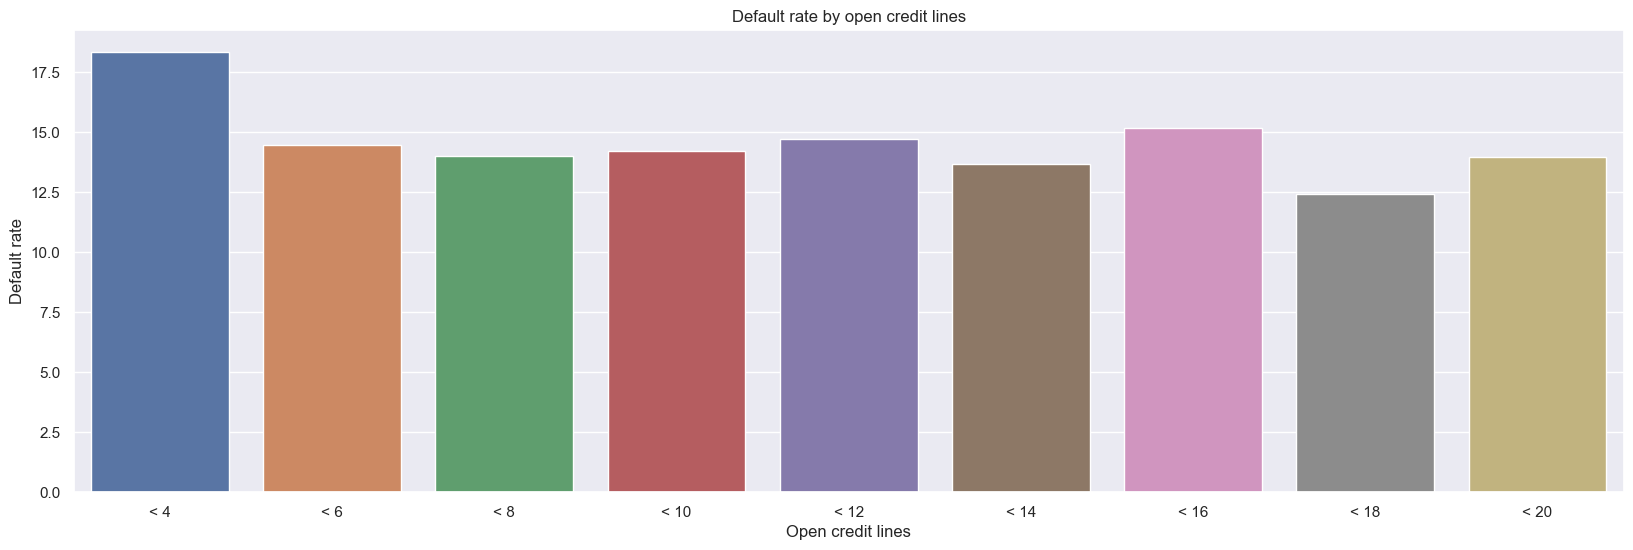

open_acc
7     3671
6     3648
8     3575
9     3344
5     2983
10    2825
11    2403
4     2217
12    1979
13    1653
3     1424
14    1277
15    1007
16     785
17     614
2      578
18     449
19     324
20     244
21     210
22     125
23      80
24      62
25      49
26      25
28      20
27      19
30      10
29       8
31       6
34       5
32       3
33       3
35       3
36       2
39       1
38       1
44       1
41       1
42       1
Name: count, dtype: int64


In [52]:
# plot default rate by binned open credit lines
plt.figure(figsize=(20, 6))
default_rate_open_acc = loans[['open_acc', 'default']].copy()
# remove outliers for open_acc
default_rate_open_acc = default_rate_open_acc[default_rate_open_acc['open_acc'] < 20]
# bin open_acc using intervals of 2 on column 'open_acc'
bin_size = 2
bin_edges = range(int(default_rate_open_acc['open_acc'].min()), int(default_rate_open_acc['open_acc'].max() + bin_size), bin_size)
default_rate_open_acc['open_acc_bin'] = pd.cut(default_rate_open_acc['open_acc'], bins=bin_edges, include_lowest=True, right=False)
default_rate_open_acc = default_rate_open_acc.groupby(['open_acc_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='open_acc_bin', y='default', data=default_rate_open_acc)
plt.title('Default rate by open credit lines')
plt.xlabel('Open credit lines')
bar_plot.set_xticklabels([f"< {str(interval.right)}" for interval in default_rate_open_acc['open_acc_bin']])
plt.ylabel('Default rate')
plt.show()

print(loans['open_acc'].value_counts())

### Default rate by total credit lines

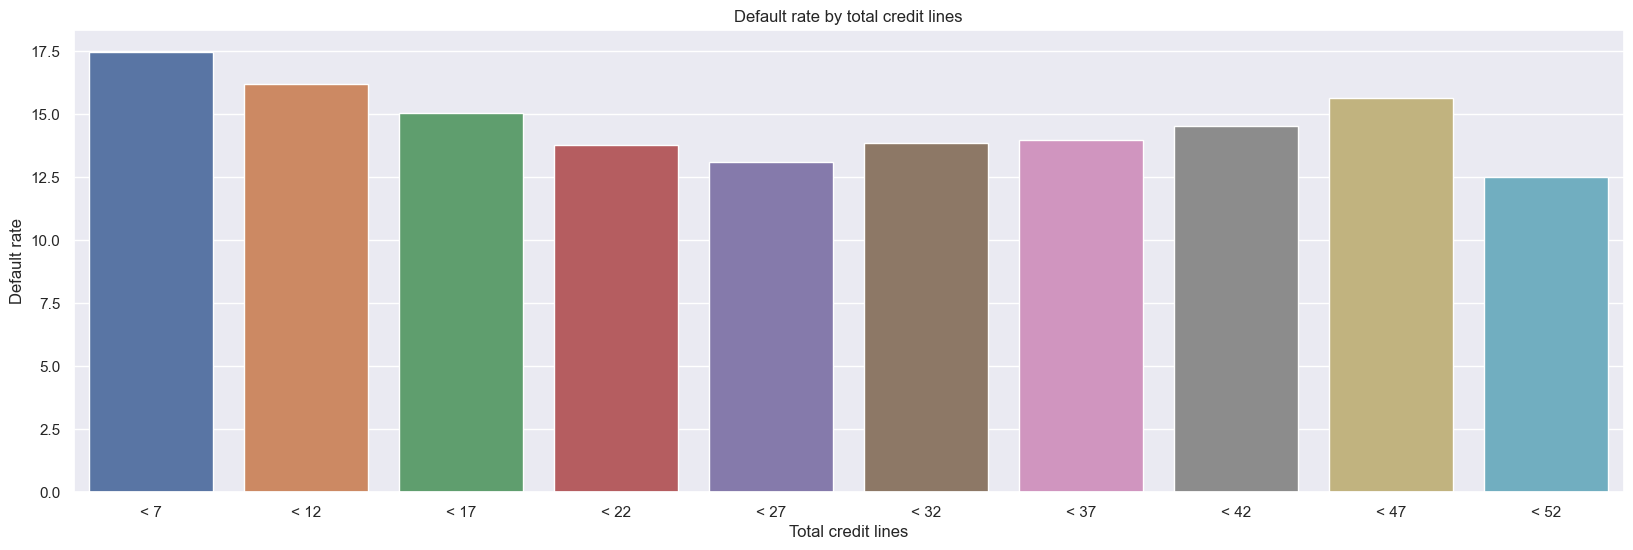

total_acc
15    1361
14    1354
16    1353
17    1334
13    1318
      ... 
69       1
73       1
70       1
68       1
87       1
Name: count, Length: 81, dtype: int64


In [55]:
# plot default rate by binned total credit lines
plt.figure(figsize=(20, 6))
default_rate_total_acc = loans[['total_acc', 'default']].copy()
# remove outliers for total_acc
default_rate_total_acc = default_rate_total_acc[default_rate_total_acc['total_acc'] < 50]
# bin total_acc using intervals of 5 on column 'total_acc'
bin_size = 5
bin_edges = range(int(default_rate_total_acc['total_acc'].min()), int(default_rate_total_acc['total_acc'].max() + bin_size), bin_size)
default_rate_total_acc['total_acc_bin'] = pd.cut(default_rate_total_acc['total_acc'], bins=bin_edges, include_lowest=True, right=False)
default_rate_total_acc = default_rate_total_acc.groupby(['total_acc_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='total_acc_bin', y='default', data=default_rate_total_acc)
plt.title('Default rate by total credit lines')
plt.xlabel('Total credit lines')
bar_plot.set_xticklabels([f"< {str(interval.right)}" for interval in default_rate_total_acc['total_acc_bin']])
plt.ylabel('Default rate')
plt.show()

print(loans['total_acc'].value_counts())

### Default rate by last credit pull month

In [63]:
print(loans['last_credit_pull_d'].value_counts())

last_credit_pull_d
2016-05-01    8570
2016-04-01    2182
2016-03-01    1049
2013-02-01     769
2016-02-01     680
              ... 
2007-09-01       2
2008-05-01       1
2008-06-01       1
2008-07-01       1
2007-07-01       1
Name: count, Length: 105, dtype: int64
